# Analysis of qPCR and ddPCR comparison data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sys
sys.path.append('../../src')
import absolute_abundance_functions as aa

In [2]:
aa.prepare_matplotlib(sm=11, md=11, bg=12)

# Parameters

In [3]:
param_dict_qpcr = {
    "NUM_OF_TECH_REPS":3,
    "MAX_CQ_SPAN_STANDARD_DIL_PT":2,
    "CQ_CUTOFF_CONC_STANDARDS":15,
    "MIN_CQ_GAP_CONC_STANDARDS": 3.11,
    "CQ_STANDARDS_SEP_LOB":2,
    "OVERHANG_ALLOWED":False,
    "CQ_NON_STANDARDS_SEP_LOB":2,
    "MAX_CQ_DIFF_SAMPLE_CLOSEST_TWO_REPS":2,
    "PCOPY":8.585e10,
    "FCOPY":1.060e11,
}

param_dict_ddpcr = {
    "DROPLET_VOLUME":0.795,
    "RXN_VOLUME":22,
    "MIN_ACCEPTED_DROPLETS":10000,
    "MIN_NEGATIVE_DROPLETS":10,
    "COPIES_RXN_LOQ_MULT":4,
}

# pcopy using NEB calculator with 3232 bp and 47.3 ng/uL * 6uL
# fcopy using NEB calculator with 3214 bp and 58.1 ng/uL * 6uL

# File paths

In [4]:
format_conversion_path = "../../artifacts/format_conversion.tsv"
layout_path = "data/layout_comparison_final.xlsx"
layout_sheet_name = "Sheet1"
qpcr_path = "data/qpcr_comparison_final.xlsx"
qpcr_sheet_name = "qPCR"

# Load files

In [5]:
format_conversion = pd.read_csv(format_conversion_path, sep="\t", names=["Well96", "Replica", "Well384"])
layout96 = pd.read_excel(layout_path, sheet_name=layout_sheet_name)
qpcr = pd.read_excel(qpcr_path, sheet_name=qpcr_sheet_name)

# Load weights

In [6]:
weights_5plicate = pd.read_csv("data/weight.tsv", sep="\t")

In [7]:
weights_5plicate

,ExtractionID,amt_dna_dry,amt_dna_wet
0,1_1,22.244444,182.0
1,1_2,22.455446,189.0
2,1_3,21.368421,174.0
3,1_4,21.368421,174.0
4,1_5,21.368421,174.0
5,2_1,19.960396,168.0
6,2_2,26.894737,219.0
7,2_3,19.756098,162.0
8,2_4,19.756098,162.0
9,2_5,19.756098,162.0


# qPCR

## Formatting

In [8]:
qpcrB, layout96 = aa.qpcr_initial_formatting(layout96, format_conversion, qpcr, param_dict_qpcr)

In [9]:
qpcrB_only_good, fewer_than_two_reps = aa.manage_tech_rep_failures(qpcrB)

In [10]:
qpcrB_only_good

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Cq
0,A01,Rep1,A1,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,18.437665
1,A01,Rep2,A2,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,18.083793
2,A01,Rep3,B1,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,18.087175
3,B01,Rep1,C1,NTC_1,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,27.553607
4,B01,Rep2,C2,NTC_1,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,26.819006
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,G12,Rep2,M24,Fpra_9,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,25.794381
284,G12,Rep3,N23,Fpra_9,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,26.003498
285,H12,Rep1,O23,Fpra_10,1,10000000000,Fpra,NaN,NaN,Fpra_10,Fpra,10000000000,27.878402
286,H12,Rep2,O24,Fpra_10,1,10000000000,Fpra,NaN,NaN,Fpra_10,Fpra,10000000000,26.609305


In [11]:
fewer_than_two_reps

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Cq
18,G01,Rep1,M1,NIST_mix_A_R,10000,1,PCRPos,NaN,NaN,NIST_mix_A_R,PCRPos,10000,NaN
19,G01,Rep2,M2,NIST_mix_A_R,10000,1,PCRPos,NaN,NaN,NIST_mix_A_R,PCRPos,10000,17.651993
20,G01,Rep3,N1,NIST_mix_A_R,10000,1,PCRPos,NaN,NaN,NIST_mix_A_R,PCRPos,10000,NaN


In [12]:
qpcrB_only_good.Name.value_counts().value_counts()

count
3    95
Name: count, dtype: int64

In [13]:
qpcr2 = aa.sort_by_well_96(pd.concat([qpcrB_only_good, fewer_than_two_reps]))

In [14]:
qpcr2.Name.value_counts().value_counts()

count
3    96
Name: count, dtype: int64

## Assess NTC

In [15]:
Cq_NTC_span, param_dict_qpcr = aa.assess_NTC(qpcr2, param_dict_qpcr)

In [16]:
Cq_NTC_span

0.9537318380196638

In [17]:
param_dict_qpcr["CQ_LIMIT_OF_BLANK"]

26.366824205258432

## Prepare Qubit HS copies for standard curve

In [18]:
pvul1 = qpcr2[qpcr2["Type"].isin(["Pvul"])].copy()
fpra1 = qpcr2[qpcr2["Type"].isin(["Fpra"])].copy()
pvul2 = aa.calculate_qubit_copies(pvul1, param_dict_qpcr["PCOPY"])
fpra2 = aa.calculate_qubit_copies(fpra1, param_dict_qpcr["FCOPY"])

## Visualize standard curve

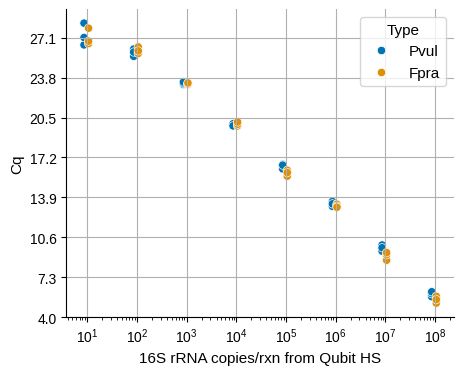

In [19]:
aa.visualize_standards(df_p=pvul2, df_f=fpra2)

## Assess standard curve

In [20]:
pvul3, p_var_dilutions_removed = aa.remove_dilutions_with_tech_rep_variation(pvul2, param_dict_qpcr)
fpra3, f_var_dilutions_removed = aa.remove_dilutions_with_tech_rep_variation(fpra2, param_dict_qpcr)
p_var_dilutions_removed_number = p_var_dilutions_removed["Dilution"].nunique()
f_var_dilutions_removed_number = f_var_dilutions_removed["Dilution"].nunique()

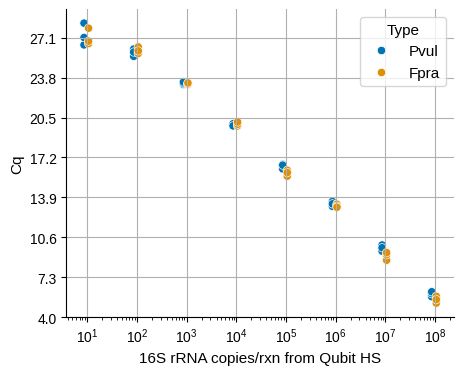

In [21]:
aa.visualize_standards(df_p=pvul3, df_f=fpra3)

In [22]:
p_var_dilutions_removed_number

0

In [23]:
f_var_dilutions_removed_number

0

In [24]:
pvul4, p_conc_dilutions_removed = aa.remove_concentrated_standards(pvul3, param_dict_qpcr)
fpra4, f_conc_dilutions_removed = aa.remove_concentrated_standards(fpra3, param_dict_qpcr)

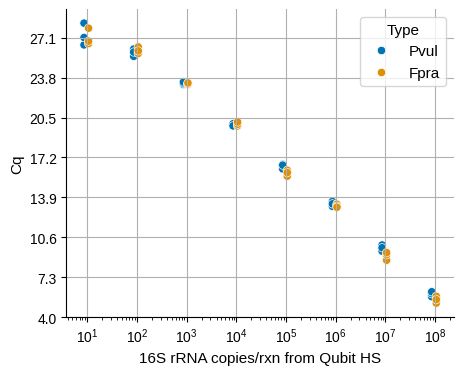

In [25]:
aa.visualize_standards(df_p=pvul4, df_f=fpra4)

In [26]:
pvul5, p_dil_dilutions_removed = aa.remove_dilute_standards(pvul4, param_dict_qpcr)
fpra5, f_dil_dilutions_removed = aa.remove_dilute_standards(fpra4, param_dict_qpcr)

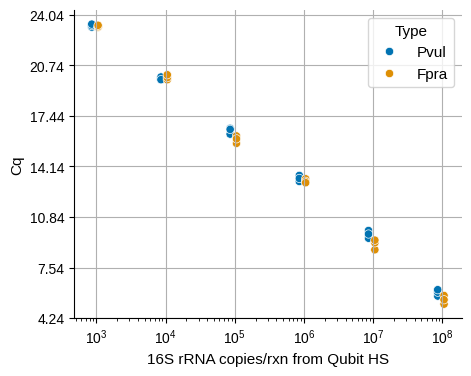

In [27]:
aa.visualize_standards(df_p=pvul5, df_f=fpra5)

## Compare the two plasmids

In [28]:
maximum_pvul_fpra_discrepancy = aa.compare_pvul_fpra(pvul5, fpra5)
maximum_pvul_fpra_discrepancy

1.2027627233968639

## Standard curve

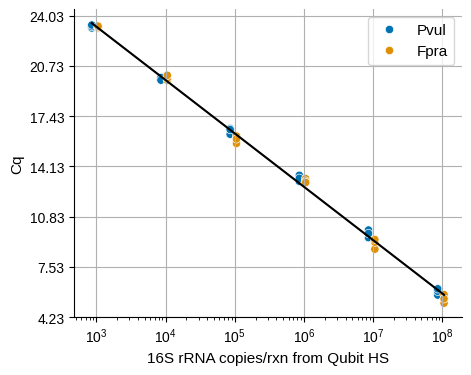

In [29]:
smodel, param_dict_qpcr = aa.final_linear_regression(pvul5, fpra5, param_dict_qpcr)
aa.plot_standard_model(pvul5, fpra5, smodel)

In [30]:
smodel

LinregressResult(slope=-3.5066148943581537, intercept=33.839041018617884, rvalue=-0.9988044226091484, pvalue=3.67632833806868e-46, stderr=0.02943351677735716, intercept_stderr=0.16893899177558958)

In [31]:
smodel.rvalue*smodel.rvalue

0.9976102746235943

In [32]:
10**(1/3.5066) - 1

0.9283085383560821

## Limit of quantification

In [33]:
param_dict_qpcr = aa.calculate_cq_limit_of_quantification(param_dict_qpcr)

In [34]:
param_dict_qpcr["CQ_LIMIT_OF_QUANTIFICATION"]

23.330193730724343

## Copies per reaction limit of blank

In [35]:
param_dict_qpcr = aa.qpcr_calculate_copies_per_reaction_lob(smodel, param_dict_qpcr)

In [36]:
param_dict_qpcr["COPIES_RXN_LIMIT_OF_BLANK"]

135.17356518561337

## Assess technical replicates

In [37]:
samples_controls = qpcr2[qpcr2["Type"].isin(["PCRPos", "PCRNeg", "DNAPos", "DNANeg", "Sample", "Pvul", "Fpra"])]
samples_controls2, samples_controls_high_variation = aa.identify_samples_with_tech_rep_variation(samples_controls, param_dict_qpcr)

In [38]:
samples_controls2

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Cq
0,A01,Rep1,A1,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,18.437665
1,A01,Rep2,A2,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,18.083793
2,A01,Rep3,B1,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,18.087175
3,B01,Rep1,C1,NTC_1,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,27.553607
4,B01,Rep2,C2,NTC_1,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,26.819006
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,G12,Rep2,M24,Fpra_9,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,25.794381
284,G12,Rep3,N23,Fpra_9,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,26.003498
285,H12,Rep1,O23,Fpra_10,1,10000000000,Fpra,NaN,NaN,Fpra_10,Fpra,10000000000,27.878402
286,H12,Rep2,O24,Fpra_10,1,10000000000,Fpra,NaN,NaN,Fpra_10,Fpra,10000000000,26.609305


In [39]:
samples_controls_high_variation

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Cq,reason_for_removal


## Calculate medians

In [40]:
samples_controls3 = aa.calculate_medians(pd.concat([samples_controls2, samples_controls_high_variation]).copy(), layout96)

In [41]:
samples_controls3

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution
0,Fpra_10,26.806919,27.878402,26.609305,H12,1,10000000000,Fpra,NaN,NaN,Fpra_10,Fpra,10000000000
1,Fpra_3,5.436296,5.712805,5.150712,A12,1,1000,Fpra,NaN,NaN,Fpra_3,Fpra,1000
2,Fpra_4,9.153459,9.326264,8.698923,B12,1,10000,Fpra,NaN,NaN,Fpra_4,Fpra,10000
3,Fpra_5,13.166439,13.330147,13.077560,C12,1,100000,Fpra,NaN,NaN,Fpra_5,Fpra,100000
4,Fpra_6,15.940452,16.129914,15.646446,D12,1,1000000,Fpra,NaN,NaN,Fpra_6,Fpra,1000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,sample_70,25.376448,25.485021,24.775725,F10,1,10000000,Sample,NaN,NaN,I,high,10000000
92,sample_71,26.270570,26.995989,25.944641,G10,1,100000000,Sample,NaN,NaN,I,high,100000000
93,sample_72,26.246691,27.460478,25.153820,H10,1,1000000000,Sample,NaN,NaN,I,high,1000000000
94,sample_8,18.249001,18.275304,18.122754,H02,10000,1,Sample,2.0,3.0,2_3,5plicate,10000


## Check for being on standard curve

In [42]:
samples_controls4, samples_controls_too_dilute, samples_controls_too_conc = aa.cq_falls_in_quantifiable_range(
        samples_controls3, param_dict_qpcr
    )

In [43]:
samples_controls_too_dilute

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,reason_for_removal
0,Fpra_10,26.806919,27.878402,26.609305,H12,1,10000000000,Fpra,NaN,NaN,Fpra_10,Fpra,10000000000,too_dilute
7,Fpra_9,26.003498,26.329172,25.794381,G12,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,too_dilute
12,NTC_1,26.819006,27.553607,26.443508,B01,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,too_dilute
13,NTC_2,26.366824,27.200091,26.245499,D01,1,1,PCRNeg,NaN,NaN,NTC_2,PCRNeg,1,too_dilute
14,NTC_3,26.444593,27.951501,26.264397,F01,1,1,PCRNeg,NaN,NaN,NTC_3,PCRNeg,1,too_dilute
15,NTC_4,27.320556,27.342452,26.682288,H01,1,1,PCRNeg,NaN,NaN,NTC_4,PCRNeg,1,too_dilute
16,Pvul_10,27.109246,28.298097,26.498849,H11,1,10000000000,Pvul,NaN,NaN,Pvul_10,Pvul,10000000000,too_dilute
23,Pvul_9,25.906566,26.153380,25.553240,G11,1,1000000000,Pvul,NaN,NaN,Pvul_9,Pvul,1000000000,too_dilute
67,sample_49,25.531106,25.719472,25.440540,A08,10,1,Sample,NaN,NaN,A,low,10,too_dilute
69,sample_50,25.234028,25.412413,25.105152,B08,10,1,Sample,NaN,NaN,B,low,10,too_dilute


In [44]:
samples_controls_too_conc

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,reason_for_removal


## Calculate copies per reaction from qPCR

In [45]:
samples_controls5 = pd.concat([samples_controls4, samples_controls_too_dilute]).copy()
samples_controls6 = aa.qpcr_calculate_copies_from_df(samples_controls5, smodel)

In [46]:
samples_controls6

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,reason_for_removal,copies_reaction
1,Fpra_3,5.436296,5.712805,5.150712,A12,1,1000,Fpra,NaN,NaN,Fpra_3,Fpra,1000,NaN,1.258235e+08
2,Fpra_4,9.153459,9.326264,8.698923,B12,1,10000,Fpra,NaN,NaN,Fpra_4,Fpra,10000,NaN,1.095768e+07
3,Fpra_5,13.166439,13.330147,13.077560,C12,1,100000,Fpra,NaN,NaN,Fpra_5,Fpra,100000,NaN,7.858069e+05
4,Fpra_6,15.940452,16.129914,15.646446,D12,1,1000000,Fpra,NaN,NaN,Fpra_6,Fpra,1000000,NaN,1.271264e+05
5,Fpra_7,19.935083,20.124024,19.802506,E12,1,10000000,Fpra,NaN,NaN,Fpra_7,Fpra,10000000,NaN,9.227110e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,sample_62,25.690668,26.088757,25.527081,F09,100,1,Sample,NaN,NaN,F,low,100,too_dilute,2.107244e+02
83,sample_63,25.174363,25.247341,25.110291,G09,100,1,Sample,NaN,NaN,G,low,100,too_dilute,2.957687e+02
91,sample_70,25.376448,25.485021,24.775725,F10,1,10000000,Sample,NaN,NaN,I,high,10000000,too_dilute,2.590136e+02
92,sample_71,26.270570,26.995989,25.944641,G10,1,100000000,Sample,NaN,NaN,I,high,100000000,too_dilute,1.439929e+02


In [47]:
samples_controls6[samples_controls6["Type"].isin(["Sample", "PCRPos", "DNANeg", "DNAPos", "PCRNeg"])].Cq_median.nsmallest(10)

85     8.266039
86    12.122599
87    15.500907
66    16.093318
28    16.979506
29    17.144665
30    17.170331
26    17.263709
33    17.434550
36    17.436824
Name: Cq_median, dtype: float64

<Axes: xlabel='Well96', ylabel='Cq_median'>

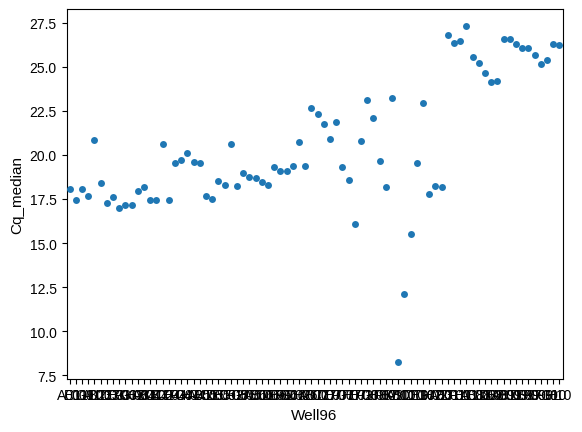

In [48]:
sns.stripplot(samples_controls6[samples_controls6["Type"].isin(["Sample", "PCRPos", "DNANeg", "DNAPos", "PCRNeg"])], x="Well96", y="Cq_median")

In [49]:
param_dict_qpcr

{'NUM_OF_TECH_REPS': 3,
 'MAX_CQ_SPAN_STANDARD_DIL_PT': 2,
 'CQ_CUTOFF_CONC_STANDARDS': 15,
 'MIN_CQ_GAP_CONC_STANDARDS': 3.11,
 'CQ_STANDARDS_SEP_LOB': 2,
 'OVERHANG_ALLOWED': False,
 'CQ_NON_STANDARDS_SEP_LOB': 2,
 'MAX_CQ_DIFF_SAMPLE_CLOSEST_TWO_REPS': 2,
 'PCOPY': 85850000000.0,
 'FCOPY': 106000000000.0,
 'CQ_LIMIT_OF_BLANK': 26.366824205258432,
 'CQ_OF_MOST_DILUTE_STANDARD_POINT': 23.330193730724343,
 'CQ_OF_MOST_CONC_STANDARD_POINT': 5.4362962163366895,
 'CQ_LIMIT_OF_QUANTIFICATION': 23.330193730724343,
 'COPIES_RXN_LIMIT_OF_BLANK': 135.17356518561337}

In [50]:
smodel

LinregressResult(slope=-3.5066148943581537, intercept=33.839041018617884, rvalue=-0.9988044226091484, pvalue=3.67632833806868e-46, stderr=0.02943351677735716, intercept_stderr=0.16893899177558958)

In [51]:
10 ** ((param_dict_qpcr["CQ_OF_MOST_CONC_STANDARD_POINT"] - smodel.intercept) / smodel.slope)

125823464.31100544

In [52]:
qpcr_copies_rxn_limit_of_quantification = 10 ** ((param_dict_qpcr["CQ_LIMIT_OF_QUANTIFICATION"] - smodel.intercept) / smodel.slope)
qpcr_copies_rxn_limit_of_quantification

992.8046769439923

## Standard curve paper plot

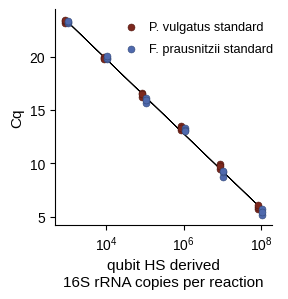

In [53]:
df = pd.concat([pvul5, fpra5])
fig, ax1 = plt.subplots(1, 1, figsize=(2.8, 2.8))
xsl = np.log10(df["Q_copies_rxn"])
xs = df["Q_copies_rxn"]
ax1.plot(xs, (smodel.intercept + smodel.slope * xsl), color="black", linewidth=0.6)
sns.scatterplot(data=df[df["Type"]=="Pvul"], x="Q_copies_rxn", y="Cq", fc="#7c281e", ax=ax1, ec="#4e160f" , zorder=5, s=25, label="Pvul")
sns.scatterplot(data=df[df["Type"]=="Fpra"], x="Q_copies_rxn", y="Cq", fc="#4f69ad", ax=ax1, ec="#324876" , zorder=5, s=25, label="Fpra")
plt.xscale("log")
sns.despine()
ax1.set_xlabel("qubit HS derived\n16S rRNA copies per reaction")
ax1.set_ylabel("Cq")

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, ["P. vulgatus standard", "F. prausnitzii standard"], bbox_to_anchor=(1.03, 0.97), loc=1, borderaxespad=0., frameon=False, labelspacing=0.8, fontsize="smaller", markerscale=1, handletextpad=0.4)

#plt.savefig('redo_plots/panel_a.pdf', format='pdf', dpi=300, bbox_inches='tight')

# ddPCR

In [54]:
ddpcr = pd.read_excel("data/ddpcr_comparison_final.xlsx", sheet_name="ddPCR")

In [55]:
ddpcr2 = aa.ddpcr_formatting(layout96, ddpcr)

In [56]:
ddpcr2

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Positives,Negatives,Accepted Droplets
0,A01,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,10632,7364,17996
1,B01,NTC_1,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,3,20965,20968
2,C01,NIST_O,10000,1,PCRPos,NaN,NaN,NIST_O,PCRPos,10000,11422,8435,19857
3,D01,NTC_2,1,1,PCRNeg,NaN,NaN,NTC_2,PCRNeg,1,4,19341,19345
4,E01,NIST_L,10000,1,PCRPos,NaN,NaN,NIST_L,PCRPos,10000,14243,4876,19119
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,D12,Fpra_6,1,1000000,Fpra,NaN,NaN,Fpra_6,Fpra,1000000,20510,286,20796
92,E12,Fpra_7,1,10000000,Fpra,NaN,NaN,Fpra_7,Fpra,10000000,5287,14938,20225
93,F12,Fpra_8,1,100000000,Fpra,NaN,NaN,Fpra_8,Fpra,100000000,677,19360,20037
94,G12,Fpra_9,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,78,20434,20512


In [57]:
ddpcr2andahalf = aa.ddpcr_calculate_copies_per_reaction_as_setup(ddpcr2, param_dict_ddpcr)

In [58]:
ddpcr2andahalf

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction
0,A01,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,10632,7364,17996,24727.065972
1,B01,NTC_1,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,3,20965,20968,3.959596
2,C01,NIST_O,10000,1,PCRPos,NaN,NaN,NIST_O,PCRPos,10000,11422,8435,19857,23692.668206
3,D01,NTC_2,1,1,PCRNeg,NaN,NaN,NTC_2,PCRNeg,1,4,19341,19345,5.722578
4,E01,NIST_L,10000,1,PCRPos,NaN,NaN,NIST_L,PCRPos,10000,14243,4876,19119,37811.147993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,D12,Fpra_6,1,1000000,Fpra,NaN,NaN,Fpra_6,Fpra,1000000,20510,286,20796,118620.793498
92,E12,Fpra_7,1,10000000,Fpra,NaN,NaN,Fpra_7,Fpra,10000000,5287,14938,20225,8385.214519
93,F12,Fpra_8,1,100000000,Fpra,NaN,NaN,Fpra_8,Fpra,100000000,677,19360,20037,951.160524
94,G12,Fpra_9,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,78,20434,20512,105.431211


In [59]:
ddpcr3, droplets_low = aa.check_num_of_droplets(ddpcr2andahalf, param_dict_ddpcr)

In [60]:
ddpcr3

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction
0,A01,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,10632,7364,17996,24727.065972
1,B01,NTC_1,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,3,20965,20968,3.959596
2,C01,NIST_O,10000,1,PCRPos,NaN,NaN,NIST_O,PCRPos,10000,11422,8435,19857,23692.668206
3,D01,NTC_2,1,1,PCRNeg,NaN,NaN,NTC_2,PCRNeg,1,4,19341,19345,5.722578
4,E01,NIST_L,10000,1,PCRPos,NaN,NaN,NIST_L,PCRPos,10000,14243,4876,19119,37811.147993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,D12,Fpra_6,1,1000000,Fpra,NaN,NaN,Fpra_6,Fpra,1000000,20510,286,20796,118620.793498
92,E12,Fpra_7,1,10000000,Fpra,NaN,NaN,Fpra_7,Fpra,10000000,5287,14938,20225,8385.214519
93,F12,Fpra_8,1,100000000,Fpra,NaN,NaN,Fpra_8,Fpra,100000000,677,19360,20037,951.160524
94,G12,Fpra_9,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,78,20434,20512,105.431211


In [61]:
droplets_low

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction
73,B10,sample_66,1,1000,Sample,NaN,NaN,I,high,1000,7699,110,7809,117957.409073


In [62]:
copies_rxn_NTC_span, param_dict_ddpcr = aa.ddpcr_determine_limit_of_blank(ddpcr3, param_dict_ddpcr)

In [63]:
param_dict_ddpcr

{'DROPLET_VOLUME': 0.795,
 'RXN_VOLUME': 22,
 'MIN_ACCEPTED_DROPLETS': 10000,
 'MIN_NEGATIVE_DROPLETS': 10,
 'COPIES_RXN_LOQ_MULT': 4,
 'COPIES_RXN_LIMIT_OF_BLANK': 5.722577898663672}

In [64]:
ddpcr4 = ddpcr3[ddpcr3["Type"].isin(["PCRPos", "DNAPos", "DNANeg", "Sample"])].copy()
ddpcr5, too_conc = aa.find_low_negative_droplets(ddpcr4, param_dict_ddpcr)

In [65]:
ddpcr6, too_dilute = aa.ddpcr_find_too_dilute(ddpcr5, param_dict_ddpcr)

In [66]:
too_conc

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction
72,A10,sample_65,1,100,Sample,NaN,NaN,I,high,100,20646,0,20646,20000000.0


In [67]:
too_dilute

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction
64,A09,sample_57,100,1,Sample,NaN,NaN,A,low,100,12,21779,21791,15.243309
66,C09,sample_59,100,1,Sample,NaN,NaN,C,low,100,15,20468,20483,20.272734
78,G10,sample_71,1,100000000,Sample,NaN,NaN,I,high,100000000,11,20254,20265,15.025175
79,H10,sample_72,1,1000000000,Sample,NaN,NaN,I,high,1000000000,3,21064,21067,3.940987


In [68]:
ddpcr4

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction
0,A01,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,10632,7364,17996,24727.065972
2,C01,NIST_O,10000,1,PCRPos,NaN,NaN,NIST_O,PCRPos,10000,11422,8435,19857,23692.668206
4,E01,NIST_L,10000,1,PCRPos,NaN,NaN,NIST_L,PCRPos,10000,14243,4876,19119,37811.147993
6,G01,NIST_mix_A_R,10000,1,PCRPos,NaN,NaN,NIST_mix_A_R,PCRPos,10000,13060,5259,18319,34535.790334
8,A02,sample_1,10000,1,Sample,1.0,1.0,1_1,5plicate,10000,2923,16449,19372,4526.300463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,D10,sample_68,1,100000,Sample,NaN,NaN,I,high,100000,4603,16324,20927,6874.066694
76,E10,sample_69,1,1000000,Sample,NaN,NaN,I,high,1000000,841,20045,20886,1137.340004
77,F10,sample_70,1,10000000,Sample,NaN,NaN,I,high,10000000,77,19952,20029,106.591643
78,G10,sample_71,1,100000000,Sample,NaN,NaN,I,high,100000000,11,20254,20265,15.025175


In [69]:
ddpcr3[ddpcr3["Negatives"] <= 10]

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Positives,Negatives,Accepted Droplets,copies_reaction
72,A10,sample_65,1,100,Sample,NaN,NaN,I,high,100,20646,0,20646,2.000000e+07
80,A11,Pvul_3,1,1000,Pvul,NaN,NaN,Pvul_3,Pvul,1000,20581,0,20581,2.000000e+07
81,B11,Pvul_4,1,10000,Pvul,NaN,NaN,Pvul_4,Pvul,10000,20836,0,20836,2.000000e+07
82,C11,Pvul_5,1,100000,Pvul,NaN,NaN,Pvul_5,Pvul,100000,19872,0,19872,2.000000e+07
88,A12,Fpra_3,1,1000,Fpra,NaN,NaN,Fpra_3,Fpra,1000,19497,1,19498,2.733553e+05
89,B12,Fpra_4,1,10000,Fpra,NaN,NaN,Fpra_4,Fpra,10000,20929,0,20929,2.000000e+07
90,C12,Fpra_5,1,100000,Fpra,NaN,NaN,Fpra_5,Fpra,100000,21031,1,21032,2.754511e+05


In [70]:
ddpcr3[ddpcr3["Negatives"] <= 10].copies_reaction.describe()

count    7.000000e+00
mean     1.436412e+07
std      9.625106e+06
min      2.733553e+05
25%      1.013773e+07
50%      2.000000e+07
75%      2.000000e+07
max      2.000000e+07
Name: copies_reaction, dtype: float64

In [71]:
ddpcr3[ddpcr3["Negatives"] > 10].copies_reaction.describe()

count        88.000000
mean      17209.924363
std       25817.187816
min           1.336955
25%         467.690319
50%        8341.695506
75%       23882.480667
max      139664.570733
Name: copies_reaction, dtype: float64

In [72]:
maximum_copies_rxn_ddpcr = 141000

In [73]:
copies_rxn_ddpcr_lod = param_dict_ddpcr["COPIES_RXN_LOQ_MULT"] * param_dict_ddpcr["COPIES_RXN_LIMIT_OF_BLANK"]
copies_rxn_ddpcr_lod

22.890311594654687

In [74]:
param_dict_ddpcr["COPIES_RXN_LIMIT_OF_BLANK"]

5.722577898663672

# merge qPCR and ddPCR

In [75]:
from_qpcr1 = samples_controls6.rename(columns={"copies_reaction":"qpcr_copies_reaction"}, inplace=False)

In [76]:
from_ddpcr1 = ddpcr3.rename(columns={"copies_reaction":"ddpcr_copies_reaction"}, inplace=False)

In [77]:
from_qpcr1

,Name,Cq_median,Cq_max,Cq_min,Well96,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction
1,Fpra_3,5.436296,5.712805,5.150712,A12,1,1000,Fpra,NaN,NaN,Fpra_3,Fpra,1000,NaN,1.258235e+08
2,Fpra_4,9.153459,9.326264,8.698923,B12,1,10000,Fpra,NaN,NaN,Fpra_4,Fpra,10000,NaN,1.095768e+07
3,Fpra_5,13.166439,13.330147,13.077560,C12,1,100000,Fpra,NaN,NaN,Fpra_5,Fpra,100000,NaN,7.858069e+05
4,Fpra_6,15.940452,16.129914,15.646446,D12,1,1000000,Fpra,NaN,NaN,Fpra_6,Fpra,1000000,NaN,1.271264e+05
5,Fpra_7,19.935083,20.124024,19.802506,E12,1,10000000,Fpra,NaN,NaN,Fpra_7,Fpra,10000000,NaN,9.227110e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,sample_62,25.690668,26.088757,25.527081,F09,100,1,Sample,NaN,NaN,F,low,100,too_dilute,2.107244e+02
83,sample_63,25.174363,25.247341,25.110291,G09,100,1,Sample,NaN,NaN,G,low,100,too_dilute,2.957687e+02
91,sample_70,25.376448,25.485021,24.775725,F10,1,10000000,Sample,NaN,NaN,I,high,10000000,too_dilute,2.590136e+02
92,sample_71,26.270570,26.995989,25.944641,G10,1,100000000,Sample,NaN,NaN,I,high,100000000,too_dilute,1.439929e+02


In [78]:
from_ddpcr1

,Well96,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Positives,Negatives,Accepted Droplets,ddpcr_copies_reaction
0,A01,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,10632,7364,17996,24727.065972
1,B01,NTC_1,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,3,20965,20968,3.959596
2,C01,NIST_O,10000,1,PCRPos,NaN,NaN,NIST_O,PCRPos,10000,11422,8435,19857,23692.668206
3,D01,NTC_2,1,1,PCRNeg,NaN,NaN,NTC_2,PCRNeg,1,4,19341,19345,5.722578
4,E01,NIST_L,10000,1,PCRPos,NaN,NaN,NIST_L,PCRPos,10000,14243,4876,19119,37811.147993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,D12,Fpra_6,1,1000000,Fpra,NaN,NaN,Fpra_6,Fpra,1000000,20510,286,20796,118620.793498
92,E12,Fpra_7,1,10000000,Fpra,NaN,NaN,Fpra_7,Fpra,10000000,5287,14938,20225,8385.214519
93,F12,Fpra_8,1,100000000,Fpra,NaN,NaN,Fpra_8,Fpra,100000000,677,19360,20037,951.160524
94,G12,Fpra_9,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,78,20434,20512,105.431211


In [79]:
qpcrddpcr = pd.merge(from_ddpcr1[["Well96", "ddpcr_copies_reaction", "Positives", "Negatives"]], from_qpcr1, how="right", on="Well96")
qpcrddpcr

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction
0,A12,2.733553e+05,19497.0,1.0,Fpra_3,5.436296,5.712805,5.150712,1,1000,Fpra,NaN,NaN,Fpra_3,Fpra,1000,NaN,1.258235e+08
1,B12,2.000000e+07,20929.0,0.0,Fpra_4,9.153459,9.326264,8.698923,1,10000,Fpra,NaN,NaN,Fpra_4,Fpra,10000,NaN,1.095768e+07
2,C12,2.754511e+05,21031.0,1.0,Fpra_5,13.166439,13.330147,13.077560,1,100000,Fpra,NaN,NaN,Fpra_5,Fpra,100000,NaN,7.858069e+05
3,D12,1.186208e+05,20510.0,286.0,Fpra_6,15.940452,16.129914,15.646446,1,1000000,Fpra,NaN,NaN,Fpra_6,Fpra,1000000,NaN,1.271264e+05
4,E12,8.385215e+03,5287.0,14938.0,Fpra_7,19.935083,20.124024,19.802506,1,10000000,Fpra,NaN,NaN,Fpra_7,Fpra,10000000,NaN,9.227110e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,F09,7.412343e+01,55.0,20506.0,sample_62,25.690668,26.088757,25.527081,100,1,Sample,NaN,NaN,F,low,100,too_dilute,2.107244e+02
92,G09,2.040788e+02,140.0,18914.0,sample_63,25.174363,25.247341,25.110291,100,1,Sample,NaN,NaN,G,low,100,too_dilute,2.957687e+02
93,F10,1.065916e+02,77.0,19952.0,sample_70,25.376448,25.485021,24.775725,1,10000000,Sample,NaN,NaN,I,high,10000000,too_dilute,2.590136e+02
94,G10,1.502517e+01,11.0,20254.0,sample_71,26.270570,26.995989,25.944641,1,100000000,Sample,NaN,NaN,I,high,100000000,too_dilute,1.439929e+02


In [80]:
qpcrddpcr[qpcrddpcr["DetailedType"].str.contains("PCRPos")]

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction
6,A01,24727.065972,10632.0,7364.0,NIST_B,18.087175,18.437665,18.083793,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,NaN,31048.690108
7,E01,37811.147993,14243.0,4876.0,NIST_L,17.467352,17.550664,17.335342,10000,1,PCRPos,NaN,NaN,NIST_L,PCRPos,10000,NaN,46644.619109
8,C01,23692.668206,11422.0,8435.0,NIST_O,18.075566,18.077779,17.861552,10000,1,PCRPos,NaN,NaN,NIST_O,PCRPos,10000,NaN,31286.282121
9,G01,34535.790334,13060.0,5259.0,NIST_mix_A_R,17.651993,17.651993,17.651993,10000,1,PCRPos,NaN,NaN,NIST_mix_A_R,PCRPos,10000,NaN,41318.684919


In [81]:
# so 1:10^3 to 1:10^5 is safe for NIST in qPCR.q
# and 1:10^4 to 10:10^5.

In [82]:
qpcrddpcr[qpcrddpcr["DetailedType"].str.contains("DNANeg")]

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction


In [83]:
qpcrddpcr[qpcrddpcr["DetailedType"].str.contains("PCRNeg")]

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction
75,B01,3.959596,3.0,20965.0,NTC_1,26.819006,27.553607,26.443508,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,too_dilute,100.447871
76,D01,5.722578,4.0,19341.0,NTC_2,26.366824,27.200091,26.245499,1,1,PCRNeg,NaN,NaN,NTC_2,PCRNeg,1,too_dilute,135.173565
77,F01,2.941897,2.0,18812.0,NTC_3,26.444593,27.951501,26.264397,1,1,PCRNeg,NaN,NaN,NTC_3,PCRNeg,1,too_dilute,128.444090
78,H01,1.336955,1.0,20698.0,NTC_4,27.320556,27.342452,26.682288,1,1,PCRNeg,NaN,NaN,NTC_4,PCRNeg,1,too_dilute,72.262169


In [84]:
qpcrddpcr[qpcrddpcr["DetailedType"].str.contains("Pvul")]

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction
10,A11,2.000000e+07,20581.0,0.0,Pvul_3,5.928904,6.091523,5.678631,1,1000,Pvul,NaN,NaN,Pvul_3,Pvul,1000,NaN,9.105046e+07
11,B11,2.000000e+07,20836.0,0.0,Pvul_4,9.726280,9.954681,9.452850,1,10000,Pvul,NaN,NaN,Pvul_4,Pvul,10000,NaN,7.522535e+06
12,C11,2.000000e+07,19872.0,0.0,Pvul_5,13.355953,13.550283,13.160273,1,100000,Pvul,NaN,NaN,Pvul_5,Pvul,100000,NaN,6.938588e+05
13,D11,8.763616e+04,20323.0,894.0,Pvul_6,16.556168,16.622771,16.249239,1,1000000,Pvul,NaN,NaN,Pvul_6,Pvul,1000000,NaN,8.484942e+04
14,E11,9.156068e+03,6054.0,15437.0,Pvul_7,19.896537,19.978062,19.802660,1,10000000,Pvul,NaN,NaN,Pvul_7,Pvul,10000000,NaN,9.463636e+03
15,F11,9.348272e+02,676.0,19675.0,Pvul_8,23.330194,23.428609,23.233503,1,100000000,Pvul,NaN,NaN,Pvul_8,Pvul,100000000,NaN,9.928047e+02
79,H11,1.364948e+01,10.0,20269.0,Pvul_10,27.109246,28.298097,26.498849,1,10000000000,Pvul,NaN,NaN,Pvul_10,Pvul,10000000000,too_dilute,8.301783e+01
80,G11,1.033910e+02,78.0,20838.0,Pvul_9,25.906566,26.153380,25.553240,1,1000000000,Pvul,NaN,NaN,Pvul_9,Pvul,1000000000,too_dilute,1.828716e+02


In [85]:
qpcrddpcr[qpcrddpcr["DetailedType"].str.contains("Fpra")]

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction
0,A12,2.733553e+05,19497.0,1.0,Fpra_3,5.436296,5.712805,5.150712,1,1000,Fpra,NaN,NaN,Fpra_3,Fpra,1000,NaN,1.258235e+08
1,B12,2.000000e+07,20929.0,0.0,Fpra_4,9.153459,9.326264,8.698923,1,10000,Fpra,NaN,NaN,Fpra_4,Fpra,10000,NaN,1.095768e+07
2,C12,2.754511e+05,21031.0,1.0,Fpra_5,13.166439,13.330147,13.077560,1,100000,Fpra,NaN,NaN,Fpra_5,Fpra,100000,NaN,7.858069e+05
3,D12,1.186208e+05,20510.0,286.0,Fpra_6,15.940452,16.129914,15.646446,1,1000000,Fpra,NaN,NaN,Fpra_6,Fpra,1000000,NaN,1.271264e+05
4,E12,8.385215e+03,5287.0,14938.0,Fpra_7,19.935083,20.124024,19.802506,1,10000000,Fpra,NaN,NaN,Fpra_7,Fpra,10000000,NaN,9.227110e+03
5,F12,9.511605e+02,677.0,19360.0,Fpra_8,23.271569,23.353279,23.227698,1,100000000,Fpra,NaN,NaN,Fpra_8,Fpra,100000000,NaN,1.031768e+03
73,H12,9.758479e+00,7.0,19847.0,Fpra_10,26.806919,27.878402,26.609305,1,10000000000,Fpra,NaN,NaN,Fpra_10,Fpra,10000000000,too_dilute,1.012482e+02
74,G12,1.054312e+02,78.0,20434.0,Fpra_9,26.003498,26.329172,25.794381,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,too_dilute,1.715946e+02


In [86]:
qpcrddpcr[qpcrddpcr["DetailedType"].str.contains("high")]

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction
65,A10,2.000000e+07,20646.0,0.0,sample_65,8.266039,8.625198,7.783745,1,100,Sample,NaN,NaN,I,high,100,NaN,1.962405e+07
66,B10,NaN,NaN,NaN,sample_66,12.122599,12.305299,11.635391,1,1000,Sample,NaN,NaN,I,high,1000,NaN,1.559528e+06
67,C10,1.396646e+05,19937.0,129.0,sample_67,15.500907,15.501175,15.240015,1,10000,Sample,NaN,NaN,I,high,10000,NaN,1.696614e+05
68,D10,6.874067e+03,4603.0,16324.0,sample_68,19.542152,19.853311,19.298274,1,100000,Sample,NaN,NaN,I,high,100000,NaN,1.194317e+04
69,E10,1.137340e+03,841.0,20045.0,sample_69,22.921265,22.995683,22.861342,1,1000000,Sample,NaN,NaN,I,high,1000000,NaN,1.298614e+03
93,F10,1.065916e+02,77.0,19952.0,sample_70,25.376448,25.485021,24.775725,1,10000000,Sample,NaN,NaN,I,high,10000000,too_dilute,2.590136e+02
94,G10,1.502517e+01,11.0,20254.0,sample_71,26.270570,26.995989,25.944641,1,100000000,Sample,NaN,NaN,I,high,100000000,too_dilute,1.439929e+02
95,H10,3.940987e+00,3.0,21064.0,sample_72,26.246691,27.460478,25.153820,1,1000000000,Sample,NaN,NaN,I,high,1000000000,too_dilute,1.462685e+02


# Make goal 1: roundtrip

In [87]:
standard_median = pd.concat([pvul3, fpra3]).copy()
grouped = standard_median.groupby("Name")["Q_copies_rxn"].median()
grouped.columns = ["qubit_copies"]
grouped = grouped.reset_index()
grouped

,Name,Q_copies_rxn
0,Fpra_10,1.060000e+01
1,Fpra_3,1.060000e+08
2,Fpra_4,1.060000e+07
3,Fpra_5,1.060000e+06
4,Fpra_6,1.060000e+05
5,Fpra_7,1.060000e+04
6,Fpra_8,1.060000e+03
7,Fpra_9,1.060000e+02
8,Pvul_10,8.585000e+00
9,Pvul_3,8.585000e+07


In [88]:
standard_median_copies = grouped.merge(qpcrddpcr[qpcrddpcr["DetailedType"].isin(["Pvul", "Fpra"])], on="Name", how="left")
standard_median_copies

,Name,Q_copies_rxn,Well96,ddpcr_copies_reaction,Positives,Negatives,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction
0,Fpra_10,1.060000e+01,H12,9.758479e+00,7.0,19847.0,26.806919,27.878402,26.609305,1,10000000000,Fpra,NaN,NaN,Fpra_10,Fpra,10000000000,too_dilute,1.012482e+02
1,Fpra_3,1.060000e+08,A12,2.733553e+05,19497.0,1.0,5.436296,5.712805,5.150712,1,1000,Fpra,NaN,NaN,Fpra_3,Fpra,1000,NaN,1.258235e+08
2,Fpra_4,1.060000e+07,B12,2.000000e+07,20929.0,0.0,9.153459,9.326264,8.698923,1,10000,Fpra,NaN,NaN,Fpra_4,Fpra,10000,NaN,1.095768e+07
3,Fpra_5,1.060000e+06,C12,2.754511e+05,21031.0,1.0,13.166439,13.330147,13.077560,1,100000,Fpra,NaN,NaN,Fpra_5,Fpra,100000,NaN,7.858069e+05
4,Fpra_6,1.060000e+05,D12,1.186208e+05,20510.0,286.0,15.940452,16.129914,15.646446,1,1000000,Fpra,NaN,NaN,Fpra_6,Fpra,1000000,NaN,1.271264e+05
5,Fpra_7,1.060000e+04,E12,8.385215e+03,5287.0,14938.0,19.935083,20.124024,19.802506,1,10000000,Fpra,NaN,NaN,Fpra_7,Fpra,10000000,NaN,9.227110e+03
6,Fpra_8,1.060000e+03,F12,9.511605e+02,677.0,19360.0,23.271569,23.353279,23.227698,1,100000000,Fpra,NaN,NaN,Fpra_8,Fpra,100000000,NaN,1.031768e+03
7,Fpra_9,1.060000e+02,G12,1.054312e+02,78.0,20434.0,26.003498,26.329172,25.794381,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,too_dilute,1.715946e+02
8,Pvul_10,8.585000e+00,H11,1.364948e+01,10.0,20269.0,27.109246,28.298097,26.498849,1,10000000000,Pvul,NaN,NaN,Pvul_10,Pvul,10000000000,too_dilute,8.301783e+01
9,Pvul_3,8.585000e+07,A11,2.000000e+07,20581.0,0.0,5.928904,6.091523,5.678631,1,1000,Pvul,NaN,NaN,Pvul_3,Pvul,1000,NaN,9.105046e+07


In [89]:
standard_median_copies["qubit/ddpcr"] = standard_median_copies["Q_copies_rxn"] / standard_median_copies["ddpcr_copies_reaction"]

In [90]:
valid_for_correction_ratio = standard_median_copies[standard_median_copies["Negatives"] > 10].copy()
valid_for_correction_ratio = valid_for_correction_ratio[valid_for_correction_ratio["ddpcr_copies_reaction"] > copies_rxn_ddpcr_lod].copy()
correction_ratio = valid_for_correction_ratio["qubit/ddpcr"].mean()
print("correction_ratio: " + str(correction_ratio))

correction_ratio: 0.9929374425128549


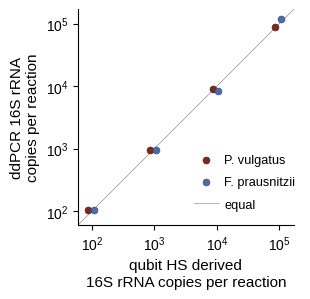

In [91]:
fig, ax1 = plt.subplots(1, 1, figsize=(2.8, 2.8))

x = np.array([10**0, 2*10**8])
y = x

sns.scatterplot(data=valid_for_correction_ratio[valid_for_correction_ratio["Type"]=="Pvul"], x="Q_copies_rxn", y="ddpcr_copies_reaction", fc="#7c281e", ax=ax1, ec="#4e160f" , zorder=5, s=25, label="Pvul")
sns.scatterplot(data=valid_for_correction_ratio[valid_for_correction_ratio["Type"]=="Fpra"], x="Q_copies_rxn", y="ddpcr_copies_reaction", fc="#4f69ad", ax=ax1, ec="#324876" , zorder=5, s=25, label="Fpra")
ax1.plot(x, y, color="#777777", linestyle="solid", linewidth=0.4, label="equal")

ax1.set_xscale("log")
ax1.set_yscale("log")
sns.despine()
ax1.set_xlabel("qubit HS derived\n16S rRNA copies per reaction")
ax1.set_ylabel("ddPCR 16S rRNA\ncopies per reaction")
ax1.set_xlim(6*10**1, 1.7*10**5)
ax1.set_ylim(6*10**1, 1.7*10**5)
ax1.minorticks_off()
ax1.set_aspect(1)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, ["P. vulgatus", "F. prausnitzii", "equal"], bbox_to_anchor=(1.03, 0.35), loc=1, borderaxespad=0., frameon=False, labelspacing=0.8, fontsize="smaller", markerscale=1, handletextpad=0.4)

#plt.savefig('redo_plots/panel_a2.pdf', format='pdf', dpi=300, bbox_inches='tight')


In [92]:
qpcrddpcr["qpcr/ddpcr"] = qpcrddpcr["qpcr_copies_reaction"] / qpcrddpcr["ddpcr_copies_reaction"]
qpcrddpcr["qpcr_adjusted_by_ddpcr_of_standard_curve"] = qpcrddpcr["qpcr_copies_reaction"] * (1.0/correction_ratio)

In [93]:
def min_diff(row):
    return min(abs(row['Cq_median'] - row['Cq_min']), abs(row['Cq_max'] - row['Cq_median']))

qpcrddpcr_good = qpcrddpcr.copy()
qpcrddpcr_good = qpcrddpcr_good[qpcrddpcr_good.apply(min_diff, axis=1) < 2].copy()

In [94]:
qpcrddpcr.shape

(96, 20)

In [95]:
qpcrddpcr_good.shape

(96, 20)

In [96]:
copies_rxn_ddpcr_lod

22.890311594654687

In [97]:
maximum_copies_rxn_ddpcr

141000

In [98]:
qpcr_copies_rxn_limit_of_quantification

992.8046769439923

In [99]:
qpcrddpcr_good.Type.value_counts()

Type
Sample    72
Fpra       8
Pvul       8
PCRPos     4
PCRNeg     4
Name: count, dtype: int64

In [100]:
qpcrddpcr_good.Name.value_counts()

Name
Fpra_3       1
Fpra_4       1
sample_7     1
sample_69    1
sample_68    1
            ..
sample_21    1
sample_20    1
sample_2     1
sample_19    1
sample_72    1
Name: count, Length: 96, dtype: int64

In [101]:
nist = qpcrddpcr[qpcrddpcr["Type"] == "PCRPos"].copy()
nist["qPCR_copies_uL"] = nist["qpcr_copies_reaction"] * nist["Dilution"] * (1/6.0)
nist["ddPCR_copies_uL"] = nist["ddpcr_copies_reaction"] * nist["Dilution"] * (1/6.0)
nist["expected_copies_uL"] = [6.223*10**7, 6.144*10**7, 5.9*10**7, 7.715*10**7]
nist["qPCR"] = nist["qPCR_copies_uL"] / nist["expected_copies_uL"]
nist["ddPCR"] = nist["ddPCR_copies_uL"] / nist["expected_copies_uL"]
nist

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,...,Dilution,reason_for_removal,qpcr_copies_reaction,qpcr/ddpcr,qpcr_adjusted_by_ddpcr_of_standard_curve,qPCR_copies_uL,ddPCR_copies_uL,expected_copies_uL,qPCR,ddPCR
6,A01,24727.065972,10632.0,7364.0,NIST_B,18.087175,18.437665,18.083793,10000,1,...,10000,NaN,31048.690108,1.255656,31269.532982,5.174782e+07,4.121178e+07,62230000.0,0.831557,0.662249
7,E01,37811.147993,14243.0,4876.0,NIST_L,17.467352,17.550664,17.335342,10000,1,...,10000,NaN,46644.619109,1.233621,46976.392582,7.774103e+07,6.301858e+07,61440000.0,1.265316,1.025693
8,C01,23692.668206,11422.0,8435.0,NIST_O,18.075566,18.077779,17.861552,10000,1,...,10000,NaN,31286.282121,1.320505,31508.814937,5.214380e+07,3.948778e+07,59000000.0,0.883793,0.669284
9,G01,34535.790334,13060.0,5259.0,NIST_mix_A_R,17.651993,17.651993,17.651993,10000,1,...,10000,NaN,41318.684919,1.196402,41612.576130,6.886447e+07,5.755965e+07,77150000.0,0.892605,0.746075


In [102]:
nist_melt2 = pd.melt(nist[["Name", "qPCR", "ddPCR"]], id_vars="Name", value_vars=["qPCR", "ddPCR"], var_name="method", value_name="measured/expected")
nist_melt2

,Name,method,measured/expected
0,NIST_B,qPCR,0.831557
1,NIST_L,qPCR,1.265316
2,NIST_O,qPCR,0.883793
3,NIST_mix_A_R,qPCR,0.892605
4,NIST_B,ddPCR,0.662249
5,NIST_L,ddPCR,1.025693
6,NIST_O,ddPCR,0.669284
7,NIST_mix_A_R,ddPCR,0.746075


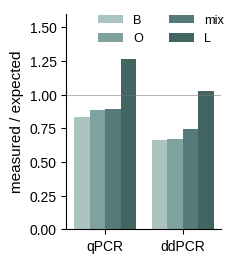

In [103]:
fig, axs = plt.subplots(1, 1, figsize=(2, 2.8))

sns.barplot(data=nist_melt2, x="method", y="measured/expected", hue="Name", palette=["#a8c8c3", "#7aa8a3", "#4d8180", "#3d6b66"], hue_order=["NIST_B", "NIST_O", "NIST_mix_A_R", "NIST_L"])

sns.lineplot(x=[-0.5, 1.5], y=[1.0, 1.0], color="#777777", linestyle="solid", linewidth=0.4)
plt.xlim(-0.5, 1.5)
plt.ylim(0.0, 1.6)
sns.despine()
plt.xlabel("")
plt.ylabel("measured / expected")

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, ["B", "O", "mix", "L"], bbox_to_anchor=(1.05, 1.02), loc=0, borderaxespad=0., frameon=False, fontsize="smaller", ncols=2)

#plt.savefig('redo_plots/panel_c.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Make goal 2: type = low plot

In [104]:
low = qpcrddpcr[qpcrddpcr["DetailedType"].isin(["low"])].copy()
low["Cq_span"] = low["Cq_max"] - low["Cq_min"]
low["case"] = low["DetailedName"]

<Axes: xlabel='DetailedName', ylabel='Cq_span'>

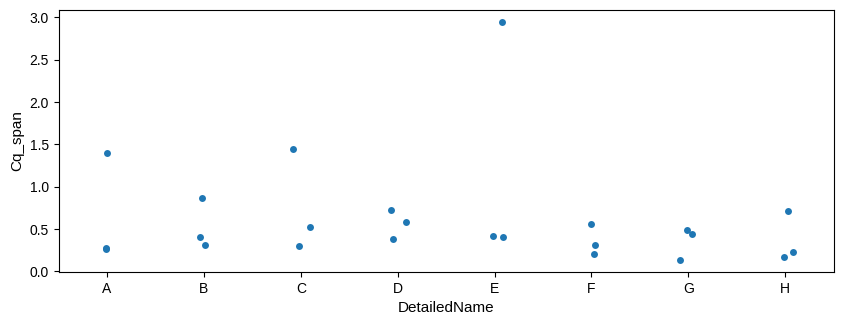

In [105]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3.4), sharey=True, gridspec_kw={'wspace': 0.1})
sns.stripplot(data=low, x="DetailedName", y="Cq_span")

In [106]:
param_dict_qpcr["COPIES_RXN_LIMIT_OF_BLANK"]

135.17356518561337

In [107]:
param_dict_ddpcr["COPIES_RXN_LIMIT_OF_BLANK"]

5.722577898663672

In [108]:
allntcvalues = qpcrddpcr[qpcrddpcr["Type"] == "PCRNeg"]
allntcvalues

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction,qpcr/ddpcr,qpcr_adjusted_by_ddpcr_of_standard_curve
75,B01,3.959596,3.0,20965.0,NTC_1,26.819006,27.553607,26.443508,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,too_dilute,100.447871,25.368213,101.162336
76,D01,5.722578,4.0,19341.0,NTC_2,26.366824,27.200091,26.245499,1,1,PCRNeg,NaN,NaN,NTC_2,PCRNeg,1,too_dilute,135.173565,23.621097,136.135027
77,F01,2.941897,2.0,18812.0,NTC_3,26.444593,27.951501,26.264397,1,1,PCRNeg,NaN,NaN,NTC_3,PCRNeg,1,too_dilute,128.444090,43.660292,129.357686
78,H01,1.336955,1.0,20698.0,NTC_4,27.320556,27.342452,26.682288,1,1,PCRNeg,NaN,NaN,NTC_4,PCRNeg,1,too_dilute,72.262169,54.049828,72.776155


In [109]:
allntcvalues["qpcr_copies_reaction"].describe()

count      4.000000
mean     109.081924
std       28.786041
min       72.262169
25%       93.401446
50%      114.445981
75%      130.126459
max      135.173565
Name: qpcr_copies_reaction, dtype: float64

In [110]:
allntcvalues["ddpcr_copies_reaction"].describe()

count    4.000000
mean     3.490256
std      1.838563
min      1.336955
25%      2.540662
50%      3.450747
75%      4.400341
max      5.722578
Name: ddpcr_copies_reaction, dtype: float64

# Combined Plot

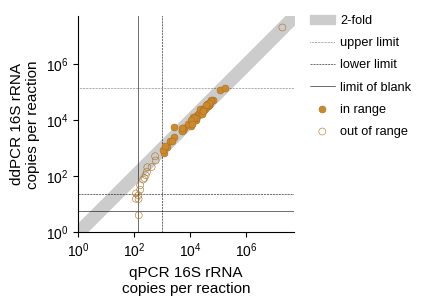

In [111]:
sol=0.4
das=0.4
dot=0.4
fig, axs = plt.subplots(1, 1, figsize=(2.8, 2.8), sharey="row", gridspec_kw={'wspace': 0.1, 'hspace':0.7})

def everything_but_scatter(axis, x_axis_label, mult=1.0):
    x = np.array([10**0, 2*10**8])
    y_2x = 2 * x
    y_x_over_2 = x / 2
    axis.fill_between(x, y_2x, y_x_over_2, color='#CCCCCC', alpha=1, label="2-fold")
    
    axis.plot([param_dict_qpcr["COPIES_RXN_LIMIT_OF_BLANK"]*mult, param_dict_qpcr["COPIES_RXN_LIMIT_OF_BLANK"]*mult], [10**0, 10**9], linestyle="solid", color="black", linewidth=sol)
    axis.plot([qpcr_copies_rxn_limit_of_quantification*mult, qpcr_copies_rxn_limit_of_quantification*mult], [10**0, 10**9], linestyle="dashed", color="black", linewidth=das)
    axis.plot([10**0, 2*10**8], [maximum_copies_rxn_ddpcr, maximum_copies_rxn_ddpcr], linestyle="dotted", color="black", label="upper limit", linewidth=dot)
    axis.plot([10**0, 2*10**8], [copies_rxn_ddpcr_lod, copies_rxn_ddpcr_lod], linestyle="dashed", color="black", label="lower limit", linewidth=das)
    axis.plot([10**0, 2*10**8], [param_dict_ddpcr["COPIES_RXN_LIMIT_OF_BLANK"], param_dict_ddpcr["COPIES_RXN_LIMIT_OF_BLANK"]], linestyle="solid", color="black", label="limit of blank", linewidth=sol)
    
    axis.set_xscale("log")
    axis.set_yscale("log")

    axis.set_xlabel(x_axis_label)
    axis.set_xlim([1, 5*10**7])
    axis.set_ylim([1, 5*10**7])
    axis.minorticks_off()
    axis.set_aspect(1)

def cut_data_frame_for_scatter(df, qpcr_copies_min, ddpcr_copies_min, ddpcr_copies_max, mult):
    df = df.copy()
    df_in_range = df[df["ddpcr_copies_reaction"] >= ddpcr_copies_min].copy()
    df_in_range2 = df_in_range[df_in_range["ddpcr_copies_reaction"] < ddpcr_copies_max].copy()
    df_in_range3 = df_in_range2[df_in_range2["qpcr_copies_reaction"] >= (qpcr_copies_min*mult)].copy()
    valid_names = df_in_range3.Name.values
    qpcr_copies_min

    in_range = df[df["Name"].isin(valid_names)].copy()
    out_of_range = df[~df["Name"].isin(valid_names)].copy()

    return in_range, out_of_range

everything_but_scatter(axis=axs, x_axis_label="qPCR 16S rRNA\ncopies per reaction")

qpcrddpcr_for_scatter = qpcrddpcr[qpcrddpcr["Type"].isin(["PCRPos", "DNAPos", "DNANeg", "Sample"])].copy()
in_range_l, out_of_range_l = cut_data_frame_for_scatter(df=qpcrddpcr_for_scatter, qpcr_copies_min=qpcr_copies_rxn_limit_of_quantification, 
                                                      ddpcr_copies_min=copies_rxn_ddpcr_lod,
                                                      ddpcr_copies_max=maximum_copies_rxn_ddpcr, mult=1.0)

sns.scatterplot(data=in_range_l, x="qpcr_copies_reaction", y="ddpcr_copies_reaction", ax=axs, zorder=5, fc="#cd892d", ec="#a9701f", s=25, label="in range")
sns.scatterplot(data=out_of_range_l, x="qpcr_copies_reaction", y="ddpcr_copies_reaction", ax=axs, zorder=5, fc='None', ec="#a9701f", s=25, label="out of range")

axs.set_ylabel("ddPCR 16S rRNA\ncopies per reaction")

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels, bbox_to_anchor=(1.05, 1.03), loc=2, borderaxespad=0., frameon=False, labelspacing=0.8, fontsize="smaller", markerscale=1, handletextpad=0.4)

sns.despine()

#plt.savefig('redo_plots/panel_b.pdf', format='pdf', dpi=300, bbox_inches='tight')


In [112]:
in_range_l["qpcr/ddpcr"].describe()

count    59.000000
mean      1.253930
std       0.210228
min       0.453012
25%       1.137558
50%       1.214778
75%       1.353271
max       1.777985
Name: qpcr/ddpcr, dtype: float64

In [113]:
in_range_l["qpcr/ddpcr"].quantile(0.1)

1.088232579144971

In [114]:
in_range_l["qpcr/ddpcr"].quantile(0.9)

1.4991066941783824

In [115]:
qpcrddpcr_for_scatter.qpcr_copies_reaction.notna().sum()

76

In [116]:
qpcrddpcr_for_scatter.ddpcr_copies_reaction.notna().sum()

75

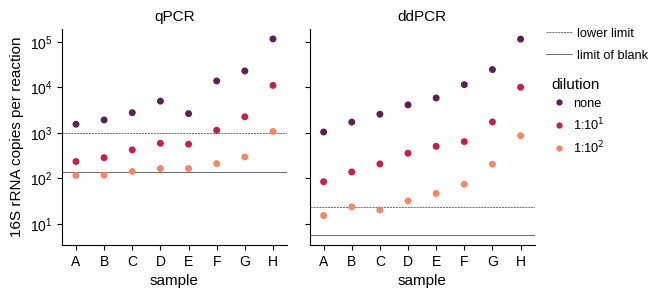

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(6.1, 2.8), sharey="row", gridspec_kw={'wspace': 0.1, 'hspace':0.7})

axs[0].plot([-0.5, 7.5], [qpcr_copies_rxn_limit_of_quantification, qpcr_copies_rxn_limit_of_quantification], linestyle="dashed", color="black", linewidth=das, label="lower limit")
axs[0].plot([-0.5, 7.5], [param_dict_qpcr["COPIES_RXN_LIMIT_OF_BLANK"], param_dict_qpcr["COPIES_RXN_LIMIT_OF_BLANK"]], linestyle="solid", color="black", linewidth=sol, label="limit of blank")
sns.stripplot(data=low, x="case", y="qpcr_copies_reaction", hue="Dilution", palette=sns.color_palette("rocket", 3), jitter=False, ax=axs[0])
axs[0].set_yscale("log")
axs[0].set_xlim([-0.5, 7.5])
axs[0].set_ylabel("16S rRNA copies per reaction")
axs[0].set_xlabel("sample")
axs[0].set_title("qPCR")
axs[0].minorticks_off()

axs[1].plot([-0.5, 7.5], [param_dict_ddpcr["COPIES_RXN_LIMIT_OF_BLANK"], param_dict_ddpcr["COPIES_RXN_LIMIT_OF_BLANK"]], linestyle="solid", color="black", linewidth=sol)
axs[1].plot([-0.5, 7.5], [copies_rxn_ddpcr_lod, copies_rxn_ddpcr_lod], linestyle="dashed", color="black", linewidth=das)
sns.stripplot(data=low, x="case", y="ddpcr_copies_reaction", hue="Dilution", palette=sns.color_palette("rocket", 3), jitter=False, ax=axs[1])
axs[1].set_yscale("log")
axs[1].set_xlim([-0.5, 7.5])
axs[1].set_ylabel("")
axs[1].set_xlabel("sample")
axs[1].set_title("ddPCR")
axs[1].minorticks_off()

sns.despine()

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[0:2], labels[0:2], bbox_to_anchor=(2.128, 1.03), loc=2, borderaxespad=0., frameon=False, labelspacing=0.8, fontsize="smaller", markerscale=1, handletextpad=0.4)

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, [f"none", f"1:10$^{{{1}}}$", f"1:10$^{{{2}}}$"], bbox_to_anchor=(1.03, 0.80), loc=2, borderaxespad=0., frameon=False, labelspacing=0.5, fontsize="smaller", markerscale=0.9, handletextpad=0.1, title="dilution")

#plt.savefig('redo_plots/panel_e.pdf', format='pdf', dpi=300, bbox_inches='tight')


In [120]:
pal = sns.color_palette("rocket_r", 3)
print(pal.as_hex())

['#f4865e', '#ca1a50', '#601f52']


In [121]:
sns.color_palette(["#f0b190", "#bf4f6e", "#704070"])
#sns.color_palette("rocket_r", 6)[0:3]

[(0.9411764705882353, 0.6941176470588235, 0.5647058823529412),
 (0.7490196078431373, 0.30980392156862746, 0.43137254901960786),
 (0.4392156862745098, 0.25098039215686274, 0.4392156862745098)]

In [122]:
sns.color_palette(['#f4865e', '#e34c78', '#704070'])

[(0.9568627450980393, 0.5254901960784314, 0.3686274509803922),
 (0.8901960784313725, 0.2980392156862745, 0.47058823529411764),
 (0.4392156862745098, 0.25098039215686274, 0.4392156862745098)]

In [207]:
sns.color_palette('flare', 5)

[(0.91262605, 0.52893336, 0.40749715),
 (0.87199254, 0.3633634, 0.35974223),
 (0.75861834, 0.25356035, 0.40663694),
 (0.60407977, 0.21017746, 0.43913439),
 (0.44584668, 0.17360625, 0.43114133)]

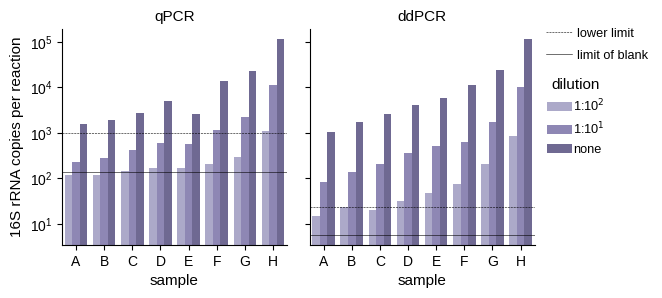

In [215]:
fig, axs = plt.subplots(1, 2, figsize=(6.1, 2.8), sharey="row", gridspec_kw={'wspace': 0.1, 'hspace':0.7})

axs[0].plot([-0.5, 7.5], [qpcr_copies_rxn_limit_of_quantification, qpcr_copies_rxn_limit_of_quantification], linestyle="dashed", color="black", linewidth=das, label="lower limit")
axs[0].plot([-0.5, 7.5], [param_dict_qpcr["COPIES_RXN_LIMIT_OF_BLANK"], param_dict_qpcr["COPIES_RXN_LIMIT_OF_BLANK"]], linestyle="solid", color="black", linewidth=sol, label="limit of blank")
sns.barplot(data=low, x="case", y="qpcr_copies_reaction", hue="Dilution", hue_order=[100, 10, 1], palette=sns.color_palette("Purples_d", 4)[0:3], ax=axs[0])
axs[0].set_yscale("log")
#axs[0].set_xlim([-0.5, 7.5]) 
axs[0].set_ylabel("16S rRNA copies per reaction")
axs[0].set_xlabel("sample")
axs[0].set_title("qPCR")
axs[0].minorticks_off()

axs[1].plot([-0.5, 7.5], [param_dict_ddpcr["COPIES_RXN_LIMIT_OF_BLANK"], param_dict_ddpcr["COPIES_RXN_LIMIT_OF_BLANK"]], linestyle="solid", color="black", linewidth=sol)
axs[1].plot([-0.5, 7.5], [copies_rxn_ddpcr_lod, copies_rxn_ddpcr_lod], linestyle="dashed", color="black", linewidth=das)
sns.barplot(data=low, x="case", y="ddpcr_copies_reaction", hue="Dilution", hue_order=[100, 10, 1], palette=sns.color_palette("Purples_d", 4)[0:3], ax=axs[1])
axs[1].set_yscale("log")
#axs[1].set_xlim([-0.5, 7.5])
axs[1].set_ylabel("")
axs[1].set_xlabel("sample")
axs[1].set_title("ddPCR")
axs[1].minorticks_off()

sns.despine()

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[0:2], labels[0:2], bbox_to_anchor=(2.128, 1.03), loc=2, borderaxespad=0., frameon=False, labelspacing=0.8, fontsize="smaller", markerscale=1, handletextpad=0.4)

handles, labels = axs[1].get_legend_handles_labels()
#axs[1].legend(handles, [f"none", f"1:10$^{{{1}}}$", f"1:10$^{{{2}}}$"], bbox_to_anchor=(1.03, 0.80), loc=2, borderaxespad=0., frameon=False, labelspacing=0.5, fontsize="smaller", markerscale=0.9, handletextpad=0.1, title="dilution")
axs[1].legend(handles, [f"1:10$^{{{2}}}$", f"1:10$^{{{1}}}$", f"none"], bbox_to_anchor=(1.03, 0.80), loc=2, borderaxespad=0., frameon=False, labelspacing=0.5, fontsize="smaller", markerscale=0.9, handletextpad=0.1, title="dilution")

#plt.savefig('redo_plots/panel_e_purple_1.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [124]:
qpcrddpcr_for_scatter.shape

(76, 20)

# Make goal 3: variances

In [125]:
samples_controls3 = aa.calculate_medians(pd.concat([samples_controls2, samples_controls_high_variation]).copy(), layout96)

In [126]:
withallreps = pd.concat([samples_controls2, samples_controls_high_variation]).copy()
withallreps["qpcr_copies_rxn_tech_reps"] = 10 ** ((withallreps["Cq"] - smodel.intercept) / smodel.slope)
withallreps["qPCR_copies_extract_tech_reps"] = withallreps["qpcr_copies_rxn_tech_reps"] * withallreps["Dilution"] * (1.0 / 6.0) * 100.0
withallreps

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Cq,reason_for_removal,qpcr_copies_rxn_tech_reps,qPCR_copies_extract_tech_reps
0,A01,Rep1,A1,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,18.437665,NaN,24665.624404,4.110937e+09
1,A01,Rep2,A2,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,18.083793,NaN,31117.728167,5.186288e+09
2,A01,Rep3,B1,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,18.087175,NaN,31048.690108,5.174782e+09
3,B01,Rep1,C1,NTC_1,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,27.553607,NaN,62.008406,1.033473e+03
4,B01,Rep2,C2,NTC_1,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,26.819006,NaN,100.447871,1.674131e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,G12,Rep2,M24,Fpra_9,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,25.794381,NaN,196.851305,3.280855e+12
284,G12,Rep3,N23,Fpra_9,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,26.003498,NaN,171.594577,2.859910e+12
285,H12,Rep1,O23,Fpra_10,1,10000000000,Fpra,NaN,NaN,Fpra_10,Fpra,10000000000,27.878402,NaN,50.098779,8.349797e+12
286,H12,Rep2,O24,Fpra_10,1,10000000000,Fpra,NaN,NaN,Fpra_10,Fpra,10000000000,26.609305,NaN,115.276914,1.921282e+13


In [127]:
qpcrtechrepcopies = withallreps[withallreps["DetailedType"] == "5plicate"].copy()
qpcrtechrepcopies

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Cq,reason_for_removal,qpcr_copies_rxn_tech_reps,qPCR_copies_extract_tech_reps
24,A02,Rep1,A3,sample_1,10000,1,Sample,1.0,1.0,1_1,5plicate,10000,20.855298,NaN,5042.467416,8.404112e+08
25,A02,Rep2,A4,sample_1,10000,1,Sample,1.0,1.0,1_1,5plicate,10000,20.846330,NaN,5072.248286,8.453747e+08
26,A02,Rep3,B3,sample_1,10000,1,Sample,1.0,1.0,1_1,5plicate,10000,20.883300,NaN,4950.594920,8.250992e+08
27,B02,Rep1,C3,sample_2,10000,1,Sample,1.0,2.0,1_2,5plicate,10000,20.831311,NaN,5122.516220,8.537527e+08
28,B02,Rep2,C4,sample_2,10000,1,Sample,1.0,2.0,1_2,5plicate,10000,20.538546,NaN,6208.301598,1.034717e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,G06,Rep2,M12,sample_39,10000,1,Sample,8.0,4.0,8_4,5plicate,10000,19.400561,NaN,13106.841428,2.184474e+09
140,G06,Rep3,N11,sample_39,10000,1,Sample,8.0,4.0,8_4,5plicate,10000,19.446783,NaN,12715.008648,2.119168e+09
141,H06,Rep1,O11,sample_40,10000,1,Sample,8.0,5.0,8_5,5plicate,10000,19.410205,NaN,13024.102902,2.170684e+09
142,H06,Rep2,O12,sample_40,10000,1,Sample,8.0,5.0,8_5,5plicate,10000,19.391855,NaN,13181.986959,2.196998e+09


In [129]:
qpcrtechrepcopies_onerep = qpcrtechrepcopies[qpcrtechrepcopies["5plicaterep"].isin([1.0])].copy()
qpcrtechrepcopies_onerep = qpcrtechrepcopies_onerep.merge(weights_5plicate[["ExtractionID", "amt_dna_dry"]].rename(columns={"ExtractionID":"DetailedName"}), 
                                                          on="DetailedName", how="left")
qpcrtechrepcopies_onerep["qPCR_copies_dryg_tech_reps"] = qpcrtechrepcopies_onerep["qPCR_copies_extract_tech_reps"] / (qpcrtechrepcopies_onerep["amt_dna_dry"] * (1/1000.0))
qpcrtechrepcopies_onerep["qpcr_log_tech_reps"] = np.log10(qpcrtechrepcopies_onerep["qPCR_copies_dryg_tech_reps"])
qpcrtechrepcopies_onerep

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Cq,reason_for_removal,qpcr_copies_rxn_tech_reps,qPCR_copies_extract_tech_reps,amt_dna_dry,qPCR_copies_dryg_tech_reps,qpcr_log_tech_reps
0,A02,Rep1,A3,sample_1,10000,1,Sample,1.0,1.0,1_1,5plicate,10000,20.855298,NaN,5042.467416,8.404112e+08,22.244444,3.778072e+10,10.577270
1,A02,Rep2,A4,sample_1,10000,1,Sample,1.0,1.0,1_1,5plicate,10000,20.846330,NaN,5072.248286,8.453747e+08,22.244444,3.800386e+10,10.579828
2,A02,Rep3,B3,sample_1,10000,1,Sample,1.0,1.0,1_1,5plicate,10000,20.883300,NaN,4950.594920,8.250992e+08,22.244444,3.709237e+10,10.569285
3,F02,Rep1,K3,sample_6,10000,1,Sample,2.0,1.0,2_1,5plicate,10000,18.053025,NaN,31752.796508,5.292133e+09,19.960396,2.651317e+11,11.423462
4,F02,Rep2,K4,sample_6,10000,1,Sample,2.0,1.0,2_1,5plicate,10000,18.181182,NaN,29190.053302,4.865009e+09,19.960396,2.437331e+11,11.386914
5,F02,Rep3,L3,sample_6,10000,1,Sample,2.0,1.0,2_1,5plicate,10000,18.481899,NaN,23959.507428,3.993251e+09,19.960396,2.000587e+11,11.301157
6,C03,Rep1,E5,sample_11,10000,1,Sample,3.0,1.0,3_1,5plicate,10000,17.263709,NaN,53318.208961,8.886368e+09,45.849057,1.938179e+11,11.287394
7,C03,Rep2,E6,sample_11,10000,1,Sample,3.0,1.0,3_1,5plicate,10000,17.413628,NaN,48319.470143,8.053245e+09,45.849057,1.756469e+11,11.244641
8,C03,Rep3,F5,sample_11,10000,1,Sample,3.0,1.0,3_1,5plicate,10000,17.239462,NaN,54173.894684,9.028982e+09,45.849057,1.969284e+11,11.294308
9,H03,Rep1,O5,sample_16,10000,1,Sample,4.0,1.0,4_1,5plicate,10000,17.702158,NaN,39979.794236,6.663299e+09,26.485507,2.515828e+11,11.400681


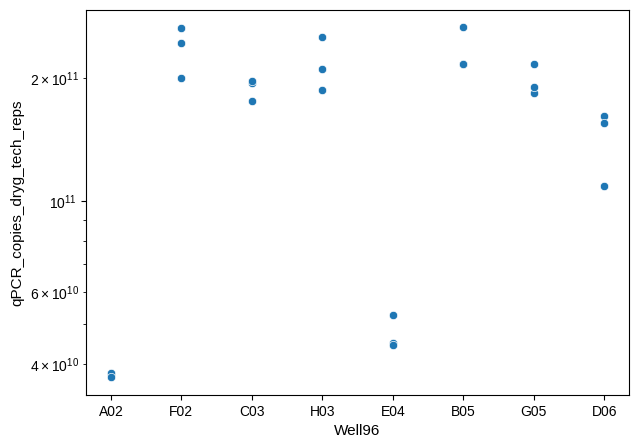

In [130]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5), sharey=True, gridspec_kw={'wspace': 0.1})
sns.scatterplot(data=qpcrtechrepcopies_onerep, x="Well96", y="qPCR_copies_dryg_tech_reps")
plt.yscale("log")

In [131]:
fiveplicate = qpcrddpcr[qpcrddpcr["DetailedType"] == "5plicate"].copy()

fiveplicate = fiveplicate.merge(weights_5plicate[["ExtractionID", "amt_dna_dry"]].rename(columns={"ExtractionID":"DetailedName"}), on="DetailedName", how="left")
fiveplicate["qPCR_copies_dryg"] = (fiveplicate["qpcr_copies_reaction"] * 10000 * (1/6.0) * 100) / (fiveplicate["amt_dna_dry"] * (1/1000.0))
fiveplicate["ddPCR_copies_dryg"] = (fiveplicate["ddpcr_copies_reaction"] * 10000 * (1/6.0) * 100) / (fiveplicate["amt_dna_dry"] * (1/1000.0))

fiveplicate["qpcr_log"] = np.log10(fiveplicate["qPCR_copies_dryg"])
fiveplicate["ddpcr_log"] = np.log10(fiveplicate["ddPCR_copies_dryg"])

In [132]:
fiveplicate_extract = fiveplicate[fiveplicate["5plicaterep"].isin([1.0, 2.0, 3.0])].copy()
fiveplicate_dil = fiveplicate[fiveplicate["5plicaterep"].isin([3.0, 4.0, 5.0])].copy()

In [133]:
variances = fiveplicate_extract.groupby("5plicatenum")["ddpcr_log"].var().reset_index()
variances.rename(columns={'ddpcr_log': 'ddpcr_log_extract_var'}, inplace=True)

variances = variances.merge(fiveplicate_extract.groupby("5plicatenum")["qpcr_log"].var().reset_index(), on="5plicatenum", how="left")
variances.rename(columns={'qpcr_log': 'qpcr_log_extract_var'}, inplace=True)

variances = variances.merge(fiveplicate_dil.groupby("5plicatenum")["ddpcr_log"].var().reset_index(), on="5plicatenum", how="left")
variances.rename(columns={'ddpcr_log': 'ddpcr_log_dil_var'}, inplace=True)

variances = variances.merge(fiveplicate_dil.groupby("5plicatenum")["qpcr_log"].var().reset_index(), on="5plicatenum", how="left")
variances.rename(columns={'qpcr_log': 'qpcr_log_dil_var'}, inplace=True)

variances = variances.merge(qpcrtechrepcopies_onerep.groupby("5plicatenum")["qpcr_log_tech_reps"].var().reset_index(), on="5plicatenum", how="left")
variances.rename(columns={"qpcr_log_tech_reps":'qpcr_log_tech_reps_var'}, inplace=True)

In [134]:
variances

,5plicatenum,ddpcr_log_extract_var,qpcr_log_extract_var,ddpcr_log_dil_var,qpcr_log_dil_var,qpcr_log_tech_reps_var
0,1.0,0.001035,0.001652,0.000649,0.000449,0.000030
1,2.0,0.000622,0.000081,0.000086,0.000927,0.003941
2,3.0,0.023003,0.023011,0.000685,0.000872,0.000724
3,4.0,0.002144,0.001295,0.000205,0.000003,0.004184
4,5.0,0.019349,0.002907,0.002019,0.007493,0.001718
5,6.0,0.015209,0.014610,0.002850,0.002040,0.002677
6,7.0,0.005283,0.002839,0.000207,0.002780,0.001393
7,8.0,0.014877,0.004761,0.000239,0.002563,0.008840


In [135]:
variances.columns.to_list()

['5plicatenum',
 'ddpcr_log_extract_var',
 'qpcr_log_extract_var',
 'ddpcr_log_dil_var',
 'qpcr_log_dil_var',
 'qpcr_log_tech_reps_var']

In [136]:
variances_melt = pd.melt(variances, id_vars='5plicatenum', value_vars=variances.columns.to_list()[1:], var_name='variable', value_name='value')

In [137]:
variances_melt

,5plicatenum,variable,value
0,1.0,ddpcr_log_extract_var,0.001035
1,2.0,ddpcr_log_extract_var,0.000622
2,3.0,ddpcr_log_extract_var,0.023003
3,4.0,ddpcr_log_extract_var,0.002144
4,5.0,ddpcr_log_extract_var,0.019349
5,6.0,ddpcr_log_extract_var,0.015209
6,7.0,ddpcr_log_extract_var,0.005283
7,8.0,ddpcr_log_extract_var,0.014877
8,1.0,qpcr_log_extract_var,0.001652
9,2.0,qpcr_log_extract_var,0.000081


<Axes: xlabel='variable', ylabel='value'>

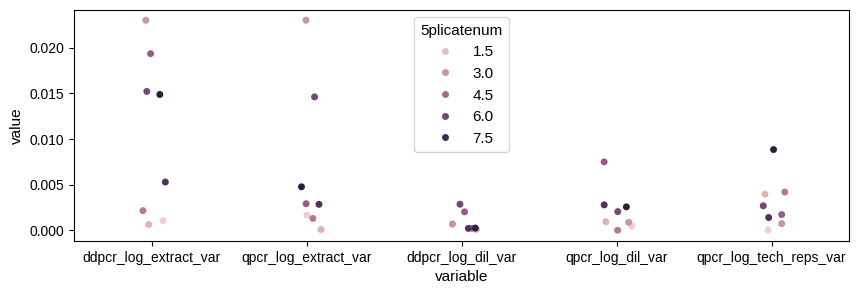

In [138]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3), sharey=True, gridspec_kw={'wspace': 0.1})
sns.stripplot(data=variances_melt, x="variable", y="value", hue="5plicatenum")

In [139]:
# bootstrapping for error estimation
bootstrap = {}

for _ in range(1000):
    for column in variances.columns:
        if column not in bootstrap:
            bootstrap[column] = []
        random_values = variances[column].sample(8, replace=True)
        bootstrap[column].append(np.mean(random_values))

bootstrap_df = pd.DataFrame(bootstrap)

In [140]:
bootstrap_df

,5plicatenum,ddpcr_log_extract_var,qpcr_log_extract_var,ddpcr_log_dil_var,qpcr_log_dil_var,qpcr_log_tech_reps_var
0,4.750,0.008447,0.007152,0.000793,0.001486,0.004630
1,5.000,0.011422,0.005211,0.001099,0.002263,0.002791
2,4.250,0.006119,0.007368,0.000667,0.001889,0.002905
3,4.750,0.009608,0.010717,0.001159,0.002906,0.003035
4,4.500,0.007410,0.008921,0.000596,0.001784,0.002862
...,...,...,...,...,...,...
995,4.125,0.010126,0.001627,0.000757,0.002978,0.003408
996,4.125,0.007458,0.006543,0.001058,0.001101,0.002697
997,5.625,0.005357,0.006596,0.001154,0.001962,0.003043
998,5.000,0.011441,0.006744,0.000534,0.001655,0.002300


In [141]:
mean_of_var = pd.DataFrame(variances.mean(), columns=['mean_of_variance']).reset_index()
mean_of_var

,index,mean_of_variance
0,5plicatenum,4.500000
1,ddpcr_log_extract_var,0.010190
2,qpcr_log_extract_var,0.006394
3,ddpcr_log_dil_var,0.000867
4,qpcr_log_dil_var,0.002141
5,qpcr_log_tech_reps_var,0.002938


In [142]:
mean_of_var2 = mean_of_var.merge(bootstrap_df.quantile(0.1).to_frame().reset_index(), on="index", how="left").merge(bootstrap_df.quantile(0.9).reset_index(), on="index", how="left").set_index("index")
mean_of_var2.columns = ["mean_of_variance", "10th", "90th"]
mean_of_var2

,mean_of_variance,10th,90th
index,,,
5plicatenum,4.500000,3.500000,5.625000
ddpcr_log_extract_var,0.010190,0.006054,0.013963
qpcr_log_extract_var,0.006394,0.003324,0.010296
ddpcr_log_dil_var,0.000867,0.000430,0.001280
qpcr_log_dil_var,0.002141,0.001153,0.003169
qpcr_log_tech_reps_var,0.002938,0.001776,0.004253


In [143]:
mean_of_var2.loc["qpcr_log_tech_reps_var", "mean_of_variance"] /= 2.23
mean_of_var2.loc["qpcr_log_tech_reps_var", "10th"] /= 2.23
mean_of_var2.loc["qpcr_log_tech_reps_var", "90th"] /= 2.23

mean_of_var2["delogged_90th_percent_mult"] = mean_of_var2["mean_of_variance"].apply(lambda x: 10**(stats.norm.ppf(0.9, loc=0, scale=(x**0.5))))
mean_of_var2["delogged_90th_percent_mult_10th"] = mean_of_var2["10th"].apply(lambda x: 10**(stats.norm.ppf(0.9, loc=0, scale=(x**0.5))))
mean_of_var2["delogged_90th_percent_mult_90th"] = mean_of_var2["90th"].apply(lambda x: 10**(stats.norm.ppf(0.9, loc=0, scale=(x**0.5))))
mean_of_var2["pos_error"] = mean_of_var2["delogged_90th_percent_mult_90th"] - mean_of_var2["delogged_90th_percent_mult"]
mean_of_var2["neg_error"] = mean_of_var2["delogged_90th_percent_mult"] - mean_of_var2["delogged_90th_percent_mult_10th"]

mean_of_var2 = mean_of_var2.rename_axis("variance_type").reset_index()
mean_of_var2 = mean_of_var2.drop(0, axis=0).reset_index(drop=True)
mean_of_var2

,variance_type,mean_of_variance,10th,90th,delogged_90th_percent_mult,delogged_90th_percent_mult_10th,delogged_90th_percent_mult_90th,pos_error,neg_error
0,ddpcr_log_extract_var,0.010190,0.006054,0.013963,1.347001,1.258088,1.417206,0.070205,0.088913
1,qpcr_log_extract_var,0.006394,0.003324,0.010296,1.266135,1.185450,1.349078,0.082943,0.080685
2,ddpcr_log_dil_var,0.000867,0.000430,0.001280,1.090797,1.063108,1.111359,0.020561,0.027690
3,qpcr_log_dil_var,0.002141,0.001153,0.003169,1.146298,1.105395,1.180707,0.034409,0.040903
4,qpcr_log_tech_reps_var,0.001318,0.000797,0.001907,1.113063,1.086847,1.137534,0.024471,0.026215


In [144]:
mean_of_var2["ddpcr_or_qpcr"] = mean_of_var2["variance_type"].str.split("_").str[0]
mean_of_var2["ddpcr_or_qpcr"] = mean_of_var2["ddpcr_or_qpcr"].map({"ddpcr":"ddPCR", "qpcr":"qPCR"})
mean_of_var2["tech_or_dil_or_extract"] = mean_of_var2["variance_type"].str.split("_").str[2]

mean_of_var2["ddpcr_or_qpcr"] = pd.Categorical(mean_of_var2["ddpcr_or_qpcr"], ["qPCR", "ddPCR"])
mean_of_var2["tech_or_dil_or_extract"] = pd.Categorical(mean_of_var2["tech_or_dil_or_extract"], ["tech", "dil", "extract"])

mean_of_var2 = mean_of_var2.sort_values(["tech_or_dil_or_extract", "ddpcr_or_qpcr"], ascending=[True, True]).reset_index()
mean_of_var2

,index,variance_type,mean_of_variance,10th,90th,delogged_90th_percent_mult,delogged_90th_percent_mult_10th,delogged_90th_percent_mult_90th,pos_error,neg_error,ddpcr_or_qpcr,tech_or_dil_or_extract
0,4,qpcr_log_tech_reps_var,0.001318,0.000797,0.001907,1.113063,1.086847,1.137534,0.024471,0.026215,qPCR,tech
1,3,qpcr_log_dil_var,0.002141,0.001153,0.003169,1.146298,1.105395,1.180707,0.034409,0.040903,qPCR,dil
2,2,ddpcr_log_dil_var,0.000867,0.000430,0.001280,1.090797,1.063108,1.111359,0.020561,0.027690,ddPCR,dil
3,1,qpcr_log_extract_var,0.006394,0.003324,0.010296,1.266135,1.185450,1.349078,0.082943,0.080685,qPCR,extract
4,0,ddpcr_log_extract_var,0.010190,0.006054,0.013963,1.347001,1.258088,1.417206,0.070205,0.088913,ddPCR,extract


In [145]:
mean_of_var2["delogged_90th_percent_mult_10th"][0]

1.0868471109620415

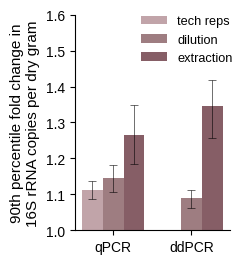

In [146]:
fig, axs = plt.subplots(1, 1, figsize=(2, 2.8), sharey=True, gridspec_kw={'wspace': 0.1})

sns.barplot(data=mean_of_var2, x="ddpcr_or_qpcr", y="delogged_90th_percent_mult", hue="tech_or_dil_or_extract", order=["qPCR", "ddPCR"], 
            hue_order=["tech", "dil", "extract"], palette=["#c69fa6", "#a3787d", "#8d5762"], ax=axs)

for i, bar in enumerate(axs.patches):
    yerr_neg = mean_of_var2["neg_error"][i]
    yerr_pos = mean_of_var2["pos_error"][i]
    axs.errorbar(
        x=bar.get_x() + bar.get_width() / 2,  # x-coordinate for the error bar
        y=bar.get_height(),                   # y-coordinate for the error bar
        yerr=[[yerr_neg], [yerr_pos]],        # Asymmetrical error bar values
        fmt='none',                           # Do not plot any marker
        capsize=3,                            # Size of error bar caps
        capthick=0.4,                           # Thickness of error bar caps
        linewidth=0.4,
        ecolor='black'                        # Color of the error bars
    )
    if i==4:
        break
    
#["#BFB7A7", "#A89283", "#736357"]
plt.ylim(1, 1.6)
plt.ylabel("90th percentile fold change in\n16S rRNA copies per dry gram")
plt.xlabel("")
sns.despine()
#axs.set_title("Variability comparison")
#plt.grid()

handles, labels = axs.get_legend_handles_labels()
legend = axs.legend(handles, ["tech reps", "dilution", "extraction"], bbox_to_anchor=(1.05, 1.02), loc=0, borderaxespad=0., frameon=False, fontsize="smaller", ncols=1)

#plt.savefig('redo_plots/panel_f.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Make goal 4: type = high

In [147]:
high = qpcrddpcr[qpcrddpcr["DetailedType"] == "high"]
high = high.merge(weights_5plicate[["ExtractionID", "amt_dna_dry"]].rename(columns={"ExtractionID":"DetailedName"}), on="DetailedName", how="left")
high["qPCR"] = (high["qpcr_copies_reaction"] * high["Dilution"] * (1/6.0) * 100) / (high["amt_dna_dry"] * (1/1000.0))
high["ddPCR"] = (high["ddpcr_copies_reaction"] * high["Dilution"] * (1/6.0) * 100) / (high["amt_dna_dry"] * (1/1000.0))
high

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,...,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction,qpcr/ddpcr,qpcr_adjusted_by_ddpcr_of_standard_curve,amt_dna_dry,qPCR,ddPCR
0,A10,2.000000e+07,20646.0,0.0,sample_65,8.266039,8.625198,7.783745,1,100,...,I,high,100,NaN,1.962405e+07,0.981203,1.976364e+07,61.842105,5.288752e+11,5.390071e+11
1,B10,NaN,NaN,NaN,sample_66,12.122599,12.305299,11.635391,1,1000,...,I,high,1000,NaN,1.559528e+06,NaN,1.570621e+06,61.842105,4.202984e+11,NaN
2,C10,1.396646e+05,19937.0,129.0,sample_67,15.500907,15.501175,15.240015,1,10000,...,I,high,10000,NaN,1.696614e+05,1.214778,1.708682e+05,61.842105,4.572435e+11,3.764010e+11
3,D10,6.874067e+03,4603.0,16324.0,sample_68,19.542152,19.853311,19.298274,1,100000,...,I,high,100000,NaN,1.194317e+04,1.737425,1.202812e+04,61.842105,3.218728e+11,1.852585e+11
4,E10,1.137340e+03,841.0,20045.0,sample_69,22.921265,22.995683,22.861342,1,1000000,...,I,high,1000000,NaN,1.298614e+03,1.141800,1.307851e+03,61.842105,3.499812e+11,3.065172e+11
5,F10,1.065916e+02,77.0,19952.0,sample_70,25.376448,25.485021,24.775725,1,10000000,...,I,high,10000000,too_dilute,2.590136e+02,2.429961,2.608559e+02,61.842105,6.980508e+11,2.872683e+11
6,G10,1.502517e+01,11.0,20254.0,sample_71,26.270570,26.995989,25.944641,1,100000000,...,I,high,100000000,too_dilute,1.439929e+02,9.583444,1.450171e+02,61.842105,3.880660e+12,4.049338e+11
7,H10,3.940987e+00,3.0,21064.0,sample_72,26.246691,27.460478,25.153820,1,1000000000,...,I,high,1000000000,too_dilute,1.462685e+02,37.114673,1.473088e+02,61.842105,3.941987e+13,1.062110e+12


In [148]:
high_melt = pd.melt(high, id_vars="Dilution", value_vars=["qPCR", "ddPCR"], var_name="method", value_name="copies_dryg")
high_melt

,Dilution,method,copies_dryg
0,100,qPCR,5.288752e+11
1,1000,qPCR,4.202984e+11
2,10000,qPCR,4.572435e+11
3,100000,qPCR,3.218728e+11
4,1000000,qPCR,3.499812e+11
5,10000000,qPCR,6.980508e+11
6,100000000,qPCR,3.880660e+12
7,1000000000,qPCR,3.941987e+13
8,100,ddPCR,5.390071e+11
9,1000,ddPCR,NaN


In [149]:
high3 = high.copy()
high3 = high3[high3["Negatives"] > 10].copy()
high3 = high3[high3["ddpcr_copies_reaction"] > copies_rxn_ddpcr_lod].copy()
high3

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,...,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction,qpcr/ddpcr,qpcr_adjusted_by_ddpcr_of_standard_curve,amt_dna_dry,qPCR,ddPCR
2,C10,139664.570733,19937.0,129.0,sample_67,15.500907,15.501175,15.240015,1,10000,...,I,high,10000,NaN,169661.389178,1.214778,170868.155348,61.842105,4.572435e+11,3.764010e+11
3,D10,6874.066694,4603.0,16324.0,sample_68,19.542152,19.853311,19.298274,1,100000,...,I,high,100000,NaN,11943.174777,1.737425,12028.124095,61.842105,3.218728e+11,1.852585e+11
4,E10,1137.340004,841.0,20045.0,sample_69,22.921265,22.995683,22.861342,1,1000000,...,I,high,1000000,NaN,1298.614288,1.141800,1307.851061,61.842105,3.499812e+11,3.065172e+11
5,F10,106.591643,77.0,19952.0,sample_70,25.376448,25.485021,24.775725,1,10000000,...,I,high,10000000,too_dilute,259.013569,2.429961,260.855878,61.842105,6.980508e+11,2.872683e+11


In [150]:
high4 = high.copy()
high4 = high4[high4["qpcr_copies_reaction"] > qpcr_copies_rxn_limit_of_quantification].copy()
high4

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,...,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction,qpcr/ddpcr,qpcr_adjusted_by_ddpcr_of_standard_curve,amt_dna_dry,qPCR,ddPCR
0,A10,2.000000e+07,20646.0,0.0,sample_65,8.266039,8.625198,7.783745,1,100,...,I,high,100,NaN,1.962405e+07,0.981203,1.976364e+07,61.842105,5.288752e+11,5.390071e+11
1,B10,NaN,NaN,NaN,sample_66,12.122599,12.305299,11.635391,1,1000,...,I,high,1000,NaN,1.559528e+06,NaN,1.570621e+06,61.842105,4.202984e+11,NaN
2,C10,1.396646e+05,19937.0,129.0,sample_67,15.500907,15.501175,15.240015,1,10000,...,I,high,10000,NaN,1.696614e+05,1.214778,1.708682e+05,61.842105,4.572435e+11,3.764010e+11
3,D10,6.874067e+03,4603.0,16324.0,sample_68,19.542152,19.853311,19.298274,1,100000,...,I,high,100000,NaN,1.194317e+04,1.737425,1.202812e+04,61.842105,3.218728e+11,1.852585e+11
4,E10,1.137340e+03,841.0,20045.0,sample_69,22.921265,22.995683,22.861342,1,1000000,...,I,high,1000000,NaN,1.298614e+03,1.141800,1.307851e+03,61.842105,3.499812e+11,3.065172e+11


In [151]:
high_melt4 = high_melt.copy()
high_melt4.loc[5, "copies_dryg"] = -1
high_melt4.loc[6, "copies_dryg"] = -1
high_melt4.loc[8, "copies_dryg"] = -1
high_melt4.loc[9, "copies_dryg"] = -1
high_melt4.loc[14, "copies_dryg"] = -1
high_melt4.drop([7, 15], axis=0, inplace=True)
high_melt4_qpcr = high_melt4[high_melt4["method"] == "qPCR"].copy()
k=1.5
high_melt4_qpcr["method"] = high_melt4_qpcr["method"].map({"qPCR":k})
high_melt4_qpcr["copies_dryg"] = [1, 1, 1, 1, 1, 1, 1]
high_melt4["method"] = high_melt4["method"].map({"qPCR":1.0, "ddPCR":2.0})
high_melt4 = pd.concat([high_melt4, high_melt4_qpcr])
high_melt4

,Dilution,method,copies_dryg
0,100,1.0,5.288752e+11
1,1000,1.0,4.202984e+11
2,10000,1.0,4.572435e+11
3,100000,1.0,3.218728e+11
4,1000000,1.0,3.499812e+11
5,10000000,1.0,-1.000000e+00
6,100000000,1.0,-1.000000e+00
8,100,2.0,-1.000000e+00
9,1000,2.0,-1.000000e+00
10,10000,2.0,3.764010e+11


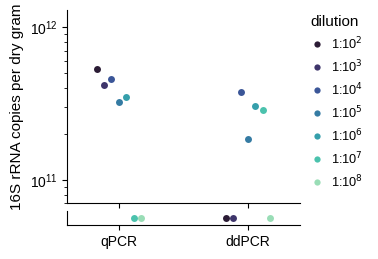

In [152]:
fig, axs = plt.subplots(2, 1, figsize=(3, 2.8), sharex=True, gridspec_kw={'height_ratios': [2, 0.15], 'hspace':0.07})

sns.swarmplot(data=high_melt4[high_melt4["method"].isin([1.0, 2.0, k])], x="method", y="copies_dryg", hue="Dilution", order=[1.0, k, 2.0], dodge=True, 
              palette=sns.color_palette("mako", 7)[0:7], ax=axs[0], native_scale=True)
axs[0].set_yscale("log")
sns.despine()
axs[0].set_ylim(7*10**10, 1.3*10**12)
axs[0].set_ylabel("16S rRNA copies per dry gram")
axs[0].set_xlabel("")
#axs[0].set_title("Dilutions of one sample")

sns.swarmplot(data=high_melt4[high_melt4["method"].isin([1.0, 2.0, k])], x="method", y="copies_dryg", hue="Dilution", order=[1.0, k, 2.0], dodge=True, 
              palette=sns.color_palette("mako", 7)[0:7], ax=axs[1], native_scale=True)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_ylabel("")
axs[1].set_ylim(-1.5, -0.5)
axs[1].set_xlabel("")

axs[0].set_xlim(0.6, 2.4)
axs[1].set_xlim(0.6, 2.4)
axs[1].set_xticks([1, 2], labels=["qPCR", "ddPCR"])

handles, labels = axs[0].get_legend_handles_labels()
handles2, _ = axs[1].get_legend_handles_labels()
handles += handles2[-1:]

axs[0].legend(handles, [f"1:10$^{{{2}}}$", f"1:10$^{{{3}}}$", f"1:10$^{{{4}}}$", f"1:10$^{{{5}}}$", f"1:10$^{{{6}}}$", f"1:10$^{{{7}}}$", 
                        f"1:10$^{{{8}}}$"], title="dilution", bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., 
              frameon=False, labelspacing=0.5, fontsize="smaller", markerscale=0.9, handletextpad=0.1)

axs[1].get_legend().remove()

#plt.savefig('redo_plots/panel_d.pdf', format='pdf', dpi=300, bbox_inches='tight')


# Make goal 3: variances per wet gram

In [153]:
samples_controls3 = aa.calculate_medians(pd.concat([samples_controls2, samples_controls_high_variation]).copy(), layout96)

In [154]:
withallreps = pd.concat([samples_controls2, samples_controls_high_variation]).copy()
withallreps["qpcr_copies_rxn_tech_reps"] = 10 ** ((withallreps["Cq"] - smodel.intercept) / smodel.slope)
withallreps["qPCR_copies_extract_tech_reps"] = withallreps["qpcr_copies_rxn_tech_reps"] * withallreps["Dilution"] * (1.0 / 6.0) * 100.0
withallreps

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Cq,reason_for_removal,qpcr_copies_rxn_tech_reps,qPCR_copies_extract_tech_reps
0,A01,Rep1,A1,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,18.437665,NaN,24665.624404,4.110937e+09
1,A01,Rep2,A2,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,18.083793,NaN,31117.728167,5.186288e+09
2,A01,Rep3,B1,NIST_B,10000,1,PCRPos,NaN,NaN,NIST_B,PCRPos,10000,18.087175,NaN,31048.690108,5.174782e+09
3,B01,Rep1,C1,NTC_1,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,27.553607,NaN,62.008406,1.033473e+03
4,B01,Rep2,C2,NTC_1,1,1,PCRNeg,NaN,NaN,NTC_1,PCRNeg,1,26.819006,NaN,100.447871,1.674131e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,G12,Rep2,M24,Fpra_9,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,25.794381,NaN,196.851305,3.280855e+12
284,G12,Rep3,N23,Fpra_9,1,1000000000,Fpra,NaN,NaN,Fpra_9,Fpra,1000000000,26.003498,NaN,171.594577,2.859910e+12
285,H12,Rep1,O23,Fpra_10,1,10000000000,Fpra,NaN,NaN,Fpra_10,Fpra,10000000000,27.878402,NaN,50.098779,8.349797e+12
286,H12,Rep2,O24,Fpra_10,1,10000000000,Fpra,NaN,NaN,Fpra_10,Fpra,10000000000,26.609305,NaN,115.276914,1.921282e+13


In [155]:
qpcrtechrepcopies = withallreps[withallreps["DetailedType"] == "5plicate"].copy()
qpcrtechrepcopies

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Cq,reason_for_removal,qpcr_copies_rxn_tech_reps,qPCR_copies_extract_tech_reps
24,A02,Rep1,A3,sample_1,10000,1,Sample,1.0,1.0,1_1,5plicate,10000,20.855298,NaN,5042.467416,8.404112e+08
25,A02,Rep2,A4,sample_1,10000,1,Sample,1.0,1.0,1_1,5plicate,10000,20.846330,NaN,5072.248286,8.453747e+08
26,A02,Rep3,B3,sample_1,10000,1,Sample,1.0,1.0,1_1,5plicate,10000,20.883300,NaN,4950.594920,8.250992e+08
27,B02,Rep1,C3,sample_2,10000,1,Sample,1.0,2.0,1_2,5plicate,10000,20.831311,NaN,5122.516220,8.537527e+08
28,B02,Rep2,C4,sample_2,10000,1,Sample,1.0,2.0,1_2,5plicate,10000,20.538546,NaN,6208.301598,1.034717e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,G06,Rep2,M12,sample_39,10000,1,Sample,8.0,4.0,8_4,5plicate,10000,19.400561,NaN,13106.841428,2.184474e+09
140,G06,Rep3,N11,sample_39,10000,1,Sample,8.0,4.0,8_4,5plicate,10000,19.446783,NaN,12715.008648,2.119168e+09
141,H06,Rep1,O11,sample_40,10000,1,Sample,8.0,5.0,8_5,5plicate,10000,19.410205,NaN,13024.102902,2.170684e+09
142,H06,Rep2,O12,sample_40,10000,1,Sample,8.0,5.0,8_5,5plicate,10000,19.391855,NaN,13181.986959,2.196998e+09


In [156]:
qpcrtechrepcopies_onerep = qpcrtechrepcopies[qpcrtechrepcopies["5plicaterep"].isin([1.0])].copy()
qpcrtechrepcopies_onerep = qpcrtechrepcopies_onerep.merge(weights_5plicate[["ExtractionID", "amt_dna_wet"]].rename(columns={"ExtractionID":"DetailedName"}), 
                                                          on="DetailedName", how="left")
qpcrtechrepcopies_onerep["qPCR_copies_wetg_tech_reps"] = qpcrtechrepcopies_onerep["qPCR_copies_extract_tech_reps"] / (qpcrtechrepcopies_onerep["amt_dna_wet"] * (1/1000.0))
qpcrtechrepcopies_onerep["qpcr_log_tech_reps"] = np.log10(qpcrtechrepcopies_onerep["qPCR_copies_wetg_tech_reps"])
qpcrtechrepcopies_onerep

,Well96,Replica,Well384,Name,LiquidHandlerDilution,SinglePipettorDilution,Type,5plicatenum,5plicaterep,DetailedName,DetailedType,Dilution,Cq,reason_for_removal,qpcr_copies_rxn_tech_reps,qPCR_copies_extract_tech_reps,amt_dna_wet,qPCR_copies_wetg_tech_reps,qpcr_log_tech_reps
0,A02,Rep1,A3,sample_1,10000,1,Sample,1.0,1.0,1_1,5plicate,10000,20.855298,NaN,5042.467416,8.404112e+08,182.0,4.617644e+09,9.664420
1,A02,Rep2,A4,sample_1,10000,1,Sample,1.0,1.0,1_1,5plicate,10000,20.846330,NaN,5072.248286,8.453747e+08,182.0,4.644916e+09,9.666978
2,A02,Rep3,B3,sample_1,10000,1,Sample,1.0,1.0,1_1,5plicate,10000,20.883300,NaN,4950.594920,8.250992e+08,182.0,4.533512e+09,9.656435
3,F02,Rep1,K3,sample_6,10000,1,Sample,2.0,1.0,2_1,5plicate,10000,18.053025,NaN,31752.796508,5.292133e+09,168.0,3.150079e+10,10.498321
4,F02,Rep2,K4,sample_6,10000,1,Sample,2.0,1.0,2_1,5plicate,10000,18.181182,NaN,29190.053302,4.865009e+09,168.0,2.895839e+10,10.461774
5,F02,Rep3,L3,sample_6,10000,1,Sample,2.0,1.0,2_1,5plicate,10000,18.481899,NaN,23959.507428,3.993251e+09,168.0,2.376935e+10,10.376017
6,C03,Rep1,E5,sample_11,10000,1,Sample,3.0,1.0,3_1,5plicate,10000,17.263709,NaN,53318.208961,8.886368e+09,243.0,3.656942e+10,10.563118
7,C03,Rep2,E6,sample_11,10000,1,Sample,3.0,1.0,3_1,5plicate,10000,17.413628,NaN,48319.470143,8.053245e+09,243.0,3.314093e+10,10.520365
8,C03,Rep3,F5,sample_11,10000,1,Sample,3.0,1.0,3_1,5plicate,10000,17.239462,NaN,54173.894684,9.028982e+09,243.0,3.715631e+10,10.570033
9,H03,Rep1,O5,sample_16,10000,1,Sample,4.0,1.0,4_1,5plicate,10000,17.702158,NaN,39979.794236,6.663299e+09,215.0,3.099209e+10,10.491251


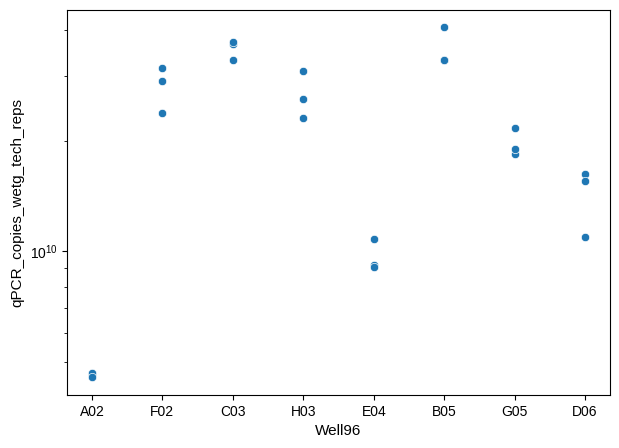

In [157]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5), sharey=True, gridspec_kw={'wspace': 0.1})
sns.scatterplot(data=qpcrtechrepcopies_onerep, x="Well96", y="qPCR_copies_wetg_tech_reps")
plt.yscale("log")

In [158]:
fiveplicate = qpcrddpcr[qpcrddpcr["DetailedType"] == "5plicate"].copy()

fiveplicate = fiveplicate.merge(weights_5plicate[["ExtractionID", "amt_dna_wet"]].rename(columns={"ExtractionID":"DetailedName"}), on="DetailedName", how="left")
fiveplicate["qPCR_copies_wetg"] = (fiveplicate["qpcr_copies_reaction"] * 10000 * (1/6.0) * 100) / (fiveplicate["amt_dna_wet"] * (1/1000.0))
fiveplicate["ddPCR_copies_wetg"] = (fiveplicate["ddpcr_copies_reaction"] * 10000 * (1/6.0) * 100) / (fiveplicate["amt_dna_wet"] * (1/1000.0))

fiveplicate["qpcr_log"] = np.log10(fiveplicate["qPCR_copies_wetg"])
fiveplicate["ddpcr_log"] = np.log10(fiveplicate["ddPCR_copies_wetg"])

In [159]:
fiveplicate_extract = fiveplicate[fiveplicate["5plicaterep"].isin([1.0, 2.0, 3.0])].copy()
fiveplicate_dil = fiveplicate[fiveplicate["5plicaterep"].isin([3.0, 4.0, 5.0])].copy()

In [160]:
variances = fiveplicate_extract.groupby("5plicatenum")["ddpcr_log"].var().reset_index()
variances.rename(columns={'ddpcr_log': 'ddpcr_log_extract_var'}, inplace=True)

variances = variances.merge(fiveplicate_extract.groupby("5plicatenum")["qpcr_log"].var().reset_index(), on="5plicatenum", how="left")
variances.rename(columns={'qpcr_log': 'qpcr_log_extract_var'}, inplace=True)

variances = variances.merge(fiveplicate_dil.groupby("5plicatenum")["ddpcr_log"].var().reset_index(), on="5plicatenum", how="left")
variances.rename(columns={'ddpcr_log': 'ddpcr_log_dil_var'}, inplace=True)

variances = variances.merge(fiveplicate_dil.groupby("5plicatenum")["qpcr_log"].var().reset_index(), on="5plicatenum", how="left")
variances.rename(columns={'qpcr_log': 'qpcr_log_dil_var'}, inplace=True)

variances = variances.merge(qpcrtechrepcopies_onerep.groupby("5plicatenum")["qpcr_log_tech_reps"].var().reset_index(), on="5plicatenum", how="left")
variances.rename(columns={"qpcr_log_tech_reps":'qpcr_log_tech_reps_var'}, inplace=True)

In [161]:
variances

,5plicatenum,ddpcr_log_extract_var,qpcr_log_extract_var,ddpcr_log_dil_var,qpcr_log_dil_var,qpcr_log_tech_reps_var
0,1.0,0.001005,0.001577,0.000649,0.000449,0.000030
1,2.0,0.000848,0.000003,0.000086,0.000927,0.003941
2,3.0,0.023189,0.022917,0.000685,0.000872,0.000724
3,4.0,0.003011,0.003233,0.000205,0.000003,0.004184
4,5.0,0.020430,0.004907,0.002019,0.007493,0.001718
5,6.0,0.025368,0.025888,0.002850,0.002040,0.002677
6,7.0,0.005283,0.002839,0.000207,0.002780,0.001393
7,8.0,0.014877,0.004761,0.000239,0.002563,0.008840


In [162]:
variances.columns.to_list()

['5plicatenum',
 'ddpcr_log_extract_var',
 'qpcr_log_extract_var',
 'ddpcr_log_dil_var',
 'qpcr_log_dil_var',
 'qpcr_log_tech_reps_var']

In [163]:
variances_melt = pd.melt(variances, id_vars='5plicatenum', value_vars=variances.columns.to_list()[1:], var_name='variable', value_name='value')

In [164]:
variances_melt

,5plicatenum,variable,value
0,1.0,ddpcr_log_extract_var,0.001005
1,2.0,ddpcr_log_extract_var,0.000848
2,3.0,ddpcr_log_extract_var,0.023189
3,4.0,ddpcr_log_extract_var,0.003011
4,5.0,ddpcr_log_extract_var,0.020430
5,6.0,ddpcr_log_extract_var,0.025368
6,7.0,ddpcr_log_extract_var,0.005283
7,8.0,ddpcr_log_extract_var,0.014877
8,1.0,qpcr_log_extract_var,0.001577
9,2.0,qpcr_log_extract_var,0.000003


<Axes: xlabel='variable', ylabel='value'>

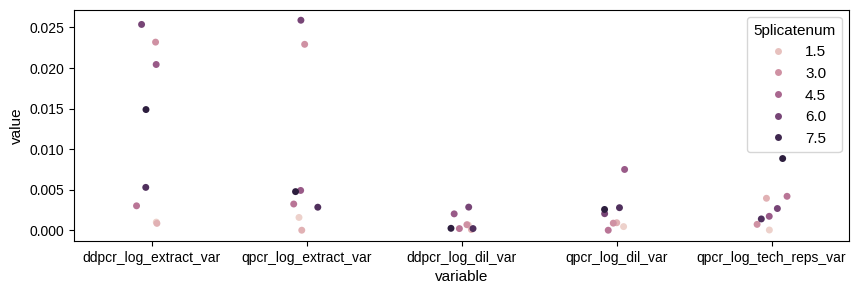

In [165]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3), sharey=True, gridspec_kw={'wspace': 0.1})
sns.stripplot(data=variances_melt, x="variable", y="value", hue="5plicatenum")

In [166]:
# bootstrapping for error estimation
bootstrap = {}

for _ in range(1000):
    for column in variances.columns:
        if column not in bootstrap:
            bootstrap[column] = []
        random_values = variances[column].sample(8, replace=True)
        bootstrap[column].append(np.mean(random_values))

bootstrap_df = pd.DataFrame(bootstrap)

In [167]:
bootstrap_df

,5plicatenum,ddpcr_log_extract_var,qpcr_log_extract_var,ddpcr_log_dil_var,qpcr_log_dil_var,qpcr_log_tech_reps_var
0,4.625,0.008746,0.007074,0.000787,0.002773,0.001954
1,5.125,0.008110,0.014187,0.000366,0.001571,0.003434
2,5.500,0.011057,0.010947,0.000689,0.002607,0.002888
3,5.375,0.007550,0.002539,0.000547,0.002535,0.003595
4,6.125,0.012788,0.011098,0.001317,0.003170,0.003902
...,...,...,...,...,...,...
995,5.500,0.018840,0.005098,0.000556,0.002173,0.002481
996,4.875,0.007063,0.011305,0.001473,0.003256,0.002293
997,4.625,0.007992,0.005592,0.000320,0.003294,0.002578
998,5.125,0.012790,0.010353,0.000314,0.002670,0.002602


In [168]:
mean_of_var = pd.DataFrame(variances.mean(), columns=['mean_of_variance']).reset_index()
mean_of_var

,index,mean_of_variance
0,5plicatenum,4.500000
1,ddpcr_log_extract_var,0.011751
2,qpcr_log_extract_var,0.008266
3,ddpcr_log_dil_var,0.000867
4,qpcr_log_dil_var,0.002141
5,qpcr_log_tech_reps_var,0.002938


In [169]:
mean_of_var2 = mean_of_var.merge(bootstrap_df.quantile(0.1).to_frame().reset_index(), on="index", how="left").merge(bootstrap_df.quantile(0.9).reset_index(), on="index", how="left").set_index("index")
mean_of_var2.columns = ["mean_of_variance", "10th", "90th"]
mean_of_var2

,mean_of_variance,10th,90th
index,,,
5plicatenum,4.500000,3.500000,5.625000
ddpcr_log_extract_var,0.011751,0.007411,0.016420
qpcr_log_extract_var,0.008266,0.003530,0.013028
ddpcr_log_dil_var,0.000867,0.000463,0.001307
qpcr_log_dil_var,0.002141,0.001167,0.003226
qpcr_log_tech_reps_var,0.002938,0.001763,0.004152


In [170]:
mean_of_var2.loc["qpcr_log_tech_reps_var", "mean_of_variance"] /= 2.23
mean_of_var2.loc["qpcr_log_tech_reps_var", "10th"] /= 2.23
mean_of_var2.loc["qpcr_log_tech_reps_var", "90th"] /= 2.23

mean_of_var2["delogged_90th_percent_mult"] = mean_of_var2["mean_of_variance"].apply(lambda x: 10**(stats.norm.ppf(0.9, loc=0, scale=(x**0.5))))
mean_of_var2["delogged_90th_percent_mult_10th"] = mean_of_var2["10th"].apply(lambda x: 10**(stats.norm.ppf(0.9, loc=0, scale=(x**0.5))))
mean_of_var2["delogged_90th_percent_mult_90th"] = mean_of_var2["90th"].apply(lambda x: 10**(stats.norm.ppf(0.9, loc=0, scale=(x**0.5))))
mean_of_var2["pos_error"] = mean_of_var2["delogged_90th_percent_mult_90th"] - mean_of_var2["delogged_90th_percent_mult"]
mean_of_var2["neg_error"] = mean_of_var2["delogged_90th_percent_mult"] - mean_of_var2["delogged_90th_percent_mult_10th"]

mean_of_var2 = mean_of_var2.rename_axis("variance_type").reset_index()
mean_of_var2 = mean_of_var2.drop(0, axis=0).reset_index(drop=True)
mean_of_var2

,variance_type,mean_of_variance,10th,90th,delogged_90th_percent_mult,delogged_90th_percent_mult_10th,delogged_90th_percent_mult_90th,pos_error,neg_error
0,ddpcr_log_extract_var,0.011751,0.007411,0.016420,1.376969,1.289213,1.459542,0.082573,0.087757
1,qpcr_log_extract_var,0.008266,0.003530,0.013028,1.307716,1.191631,1.400472,0.092756,0.116085
2,ddpcr_log_dil_var,0.000867,0.000463,0.001307,1.090797,1.065539,1.112571,0.021773,0.025259
3,qpcr_log_dil_var,0.002141,0.001167,0.003226,1.146298,1.106077,1.182471,0.036173,0.040221
4,qpcr_log_tech_reps_var,0.001318,0.000790,0.001862,1.113063,1.086504,1.135791,0.022728,0.026558


In [171]:
mean_of_var2["ddpcr_or_qpcr"] = mean_of_var2["variance_type"].str.split("_").str[0]
mean_of_var2["ddpcr_or_qpcr"] = mean_of_var2["ddpcr_or_qpcr"].map({"ddpcr":"ddPCR", "qpcr":"qPCR"})
mean_of_var2["tech_or_dil_or_extract"] = mean_of_var2["variance_type"].str.split("_").str[2]

mean_of_var2["ddpcr_or_qpcr"] = pd.Categorical(mean_of_var2["ddpcr_or_qpcr"], ["qPCR", "ddPCR"])
mean_of_var2["tech_or_dil_or_extract"] = pd.Categorical(mean_of_var2["tech_or_dil_or_extract"], ["tech", "dil", "extract"])

mean_of_var2 = mean_of_var2.sort_values(["tech_or_dil_or_extract", "ddpcr_or_qpcr"], ascending=[True, True]).reset_index()
mean_of_var2

,index,variance_type,mean_of_variance,10th,90th,delogged_90th_percent_mult,delogged_90th_percent_mult_10th,delogged_90th_percent_mult_90th,pos_error,neg_error,ddpcr_or_qpcr,tech_or_dil_or_extract
0,4,qpcr_log_tech_reps_var,0.001318,0.000790,0.001862,1.113063,1.086504,1.135791,0.022728,0.026558,qPCR,tech
1,3,qpcr_log_dil_var,0.002141,0.001167,0.003226,1.146298,1.106077,1.182471,0.036173,0.040221,qPCR,dil
2,2,ddpcr_log_dil_var,0.000867,0.000463,0.001307,1.090797,1.065539,1.112571,0.021773,0.025259,ddPCR,dil
3,1,qpcr_log_extract_var,0.008266,0.003530,0.013028,1.307716,1.191631,1.400472,0.092756,0.116085,qPCR,extract
4,0,ddpcr_log_extract_var,0.011751,0.007411,0.016420,1.376969,1.289213,1.459542,0.082573,0.087757,ddPCR,extract


In [172]:
mean_of_var2["delogged_90th_percent_mult_10th"][0]

1.0865040955317309

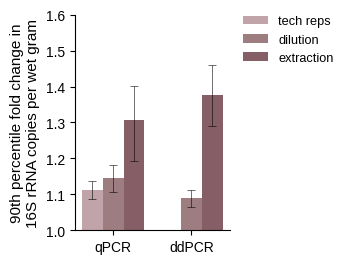

In [177]:
fig, axs = plt.subplots(1, 1, figsize=(2, 2.8), sharey=True, gridspec_kw={'wspace': 0.1})

sns.barplot(data=mean_of_var2, x="ddpcr_or_qpcr", y="delogged_90th_percent_mult", hue="tech_or_dil_or_extract", order=["qPCR", "ddPCR"], 
            hue_order=["tech", "dil", "extract"], palette=["#c69fa6", "#a3787d", "#8d5762"], ax=axs)

for i, bar in enumerate(axs.patches):
    yerr_neg = mean_of_var2["neg_error"][i]
    yerr_pos = mean_of_var2["pos_error"][i]
    axs.errorbar(
        x=bar.get_x() + bar.get_width() / 2,  # x-coordinate for the error bar
        y=bar.get_height(),                   # y-coordinate for the error bar
        yerr=[[yerr_neg], [yerr_pos]],        # Asymmetrical error bar values
        fmt='none',                           # Do not plot any marker
        capsize=3,                            # Size of error bar caps
        capthick=0.4,                           # Thickness of error bar caps
        linewidth=0.4,
        ecolor='black'                        # Color of the error bars
    )
    if i==4:
        break
    
#["#BFB7A7", "#A89283", "#736357"]
plt.ylim(1, 1.6)
plt.ylabel("90th percentile fold change in\n16S rRNA copies per wet gram")
plt.xlabel("")
sns.despine()
#axs.set_title("Variability comparison")
#plt.grid()

handles, labels = axs.get_legend_handles_labels()
legend = axs.legend(handles, ["tech reps", "dilution", "extraction"], bbox_to_anchor=(1.05, 1.02), loc=0, borderaxespad=0., frameon=False, fontsize="smaller", ncols=1)

#plt.savefig('redo_plots/panel_f_wet_gm.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Make goal 4: type = high per wet gram

In [178]:
high = qpcrddpcr[qpcrddpcr["DetailedType"] == "high"]
high = high.merge(weights_5plicate[["ExtractionID", "amt_dna_wet"]].rename(columns={"ExtractionID":"DetailedName"}), on="DetailedName", how="left")
high["qPCR"] = (high["qpcr_copies_reaction"] * high["Dilution"] * (1/6.0) * 100) / (high["amt_dna_wet"] * (1/1000.0))
high["ddPCR"] = (high["ddpcr_copies_reaction"] * high["Dilution"] * (1/6.0) * 100) / (high["amt_dna_wet"] * (1/1000.0))
high

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,...,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction,qpcr/ddpcr,qpcr_adjusted_by_ddpcr_of_standard_curve,amt_dna_wet,qPCR,ddPCR
0,A10,2.000000e+07,20646.0,0.0,sample_65,8.266039,8.625198,7.783745,1,100,...,I,high,100,NaN,1.962405e+07,0.981203,1.976364e+07,235.0,1.391777e+11,1.418440e+11
1,B10,NaN,NaN,NaN,sample_66,12.122599,12.305299,11.635391,1,1000,...,I,high,1000,NaN,1.559528e+06,NaN,1.570621e+06,235.0,1.106048e+11,NaN
2,C10,1.396646e+05,19937.0,129.0,sample_67,15.500907,15.501175,15.240015,1,10000,...,I,high,10000,NaN,1.696614e+05,1.214778,1.708682e+05,235.0,1.203272e+11,9.905289e+10
3,D10,6.874067e+03,4603.0,16324.0,sample_68,19.542152,19.853311,19.298274,1,100000,...,I,high,100000,NaN,1.194317e+04,1.737425,1.202812e+04,235.0,8.470337e+10,4.875225e+10
4,E10,1.137340e+03,841.0,20045.0,sample_69,22.921265,22.995683,22.861342,1,1000000,...,I,high,1000000,NaN,1.298614e+03,1.141800,1.307851e+03,235.0,9.210030e+10,8.066241e+10
5,F10,1.065916e+02,77.0,19952.0,sample_70,25.376448,25.485021,24.775725,1,10000000,...,I,high,10000000,too_dilute,2.590136e+02,2.429961,2.608559e+02,235.0,1.836976e+11,7.559691e+10
6,G10,1.502517e+01,11.0,20254.0,sample_71,26.270570,26.995989,25.944641,1,100000000,...,I,high,100000000,too_dilute,1.439929e+02,9.583444,1.450171e+02,235.0,1.021226e+12,1.065615e+11
7,H10,3.940987e+00,3.0,21064.0,sample_72,26.246691,27.460478,25.153820,1,1000000000,...,I,high,1000000000,too_dilute,1.462685e+02,37.114673,1.473088e+02,235.0,1.037365e+13,2.795026e+11


In [179]:
high_melt = pd.melt(high, id_vars="Dilution", value_vars=["qPCR", "ddPCR"], var_name="method", value_name="copies_wetg")
high_melt

,Dilution,method,copies_wetg
0,100,qPCR,1.391777e+11
1,1000,qPCR,1.106048e+11
2,10000,qPCR,1.203272e+11
3,100000,qPCR,8.470337e+10
4,1000000,qPCR,9.210030e+10
5,10000000,qPCR,1.836976e+11
6,100000000,qPCR,1.021226e+12
7,1000000000,qPCR,1.037365e+13
8,100,ddPCR,1.418440e+11
9,1000,ddPCR,NaN


In [180]:
high3 = high.copy()
high3 = high3[high3["Negatives"] > 10].copy()
high3 = high3[high3["ddpcr_copies_reaction"] > copies_rxn_ddpcr_lod].copy()
high3

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,...,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction,qpcr/ddpcr,qpcr_adjusted_by_ddpcr_of_standard_curve,amt_dna_wet,qPCR,ddPCR
2,C10,139664.570733,19937.0,129.0,sample_67,15.500907,15.501175,15.240015,1,10000,...,I,high,10000,NaN,169661.389178,1.214778,170868.155348,235.0,1.203272e+11,9.905289e+10
3,D10,6874.066694,4603.0,16324.0,sample_68,19.542152,19.853311,19.298274,1,100000,...,I,high,100000,NaN,11943.174777,1.737425,12028.124095,235.0,8.470337e+10,4.875225e+10
4,E10,1137.340004,841.0,20045.0,sample_69,22.921265,22.995683,22.861342,1,1000000,...,I,high,1000000,NaN,1298.614288,1.141800,1307.851061,235.0,9.210030e+10,8.066241e+10
5,F10,106.591643,77.0,19952.0,sample_70,25.376448,25.485021,24.775725,1,10000000,...,I,high,10000000,too_dilute,259.013569,2.429961,260.855878,235.0,1.836976e+11,7.559691e+10


In [181]:
high4 = high.copy()
high4 = high4[high4["qpcr_copies_reaction"] > qpcr_copies_rxn_limit_of_quantification].copy()
high4

,Well96,ddpcr_copies_reaction,Positives,Negatives,Name,Cq_median,Cq_max,Cq_min,LiquidHandlerDilution,SinglePipettorDilution,...,DetailedName,DetailedType,Dilution,reason_for_removal,qpcr_copies_reaction,qpcr/ddpcr,qpcr_adjusted_by_ddpcr_of_standard_curve,amt_dna_wet,qPCR,ddPCR
0,A10,2.000000e+07,20646.0,0.0,sample_65,8.266039,8.625198,7.783745,1,100,...,I,high,100,NaN,1.962405e+07,0.981203,1.976364e+07,235.0,1.391777e+11,1.418440e+11
1,B10,NaN,NaN,NaN,sample_66,12.122599,12.305299,11.635391,1,1000,...,I,high,1000,NaN,1.559528e+06,NaN,1.570621e+06,235.0,1.106048e+11,NaN
2,C10,1.396646e+05,19937.0,129.0,sample_67,15.500907,15.501175,15.240015,1,10000,...,I,high,10000,NaN,1.696614e+05,1.214778,1.708682e+05,235.0,1.203272e+11,9.905289e+10
3,D10,6.874067e+03,4603.0,16324.0,sample_68,19.542152,19.853311,19.298274,1,100000,...,I,high,100000,NaN,1.194317e+04,1.737425,1.202812e+04,235.0,8.470337e+10,4.875225e+10
4,E10,1.137340e+03,841.0,20045.0,sample_69,22.921265,22.995683,22.861342,1,1000000,...,I,high,1000000,NaN,1.298614e+03,1.141800,1.307851e+03,235.0,9.210030e+10,8.066241e+10


In [182]:
high_melt4 = high_melt.copy()
high_melt4.loc[5, "copies_wetg"] = -1
high_melt4.loc[6, "copies_wetg"] = -1
high_melt4.loc[8, "copies_wetg"] = -1
high_melt4.loc[9, "copies_wetg"] = -1
high_melt4.loc[14, "copies_wetg"] = -1
high_melt4.drop([7, 15], axis=0, inplace=True)
high_melt4_qpcr = high_melt4[high_melt4["method"] == "qPCR"].copy()
k=1.5
high_melt4_qpcr["method"] = high_melt4_qpcr["method"].map({"qPCR":k})
high_melt4_qpcr["copies_wetg"] = [1, 1, 1, 1, 1, 1, 1]
high_melt4["method"] = high_melt4["method"].map({"qPCR":1.0, "ddPCR":2.0})
high_melt4 = pd.concat([high_melt4, high_melt4_qpcr])
high_melt4

,Dilution,method,copies_wetg
0,100,1.0,1.391777e+11
1,1000,1.0,1.106048e+11
2,10000,1.0,1.203272e+11
3,100000,1.0,8.470337e+10
4,1000000,1.0,9.210030e+10
5,10000000,1.0,-1.000000e+00
6,100000000,1.0,-1.000000e+00
8,100,2.0,-1.000000e+00
9,1000,2.0,-1.000000e+00
10,10000,2.0,9.905289e+10


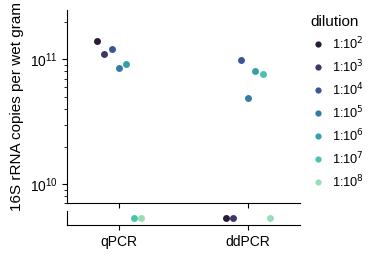

In [198]:
fig, axs = plt.subplots(2, 1, figsize=(3, 2.8), sharex=True, gridspec_kw={'height_ratios': [2, 0.15], 'hspace':0.07})

sns.swarmplot(data=high_melt4[high_melt4["method"].isin([1.0, 2.0, k])], x="method", y="copies_wetg", hue="Dilution", order=[1.0, k, 2.0], dodge=True, 
              palette=sns.color_palette("mako", 7)[0:7], ax=axs[0], native_scale=True)
axs[0].set_yscale("log")
sns.despine()
#axs[0].set_ylim(7*10**10, 1.3*10**12)
axs[0].set_ylim(7*10**9, 2.5*10**11)
axs[0].set_ylabel("16S rRNA copies per wet gram")
axs[0].set_xlabel("")
#axs[0].set_title("Dilutions of one sample")

sns.swarmplot(data=high_melt4[high_melt4["method"].isin([1.0, 2.0, k])], x="method", y="copies_wetg", hue="Dilution", order=[1.0, k, 2.0], dodge=True, 
              palette=sns.color_palette("mako", 7)[0:7], ax=axs[1], native_scale=True)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_ylabel("")
axs[1].set_ylim(-1.5, -0.5)
axs[1].set_xlabel("")

axs[0].set_xlim(0.6, 2.4)
axs[1].set_xlim(0.6, 2.4)
axs[1].set_xticks([1, 2], labels=["qPCR", "ddPCR"])

handles, labels = axs[0].get_legend_handles_labels()
handles2, _ = axs[1].get_legend_handles_labels()
handles += handles2[-1:]

axs[0].legend(handles, [f"1:10$^{{{2}}}$", f"1:10$^{{{3}}}$", f"1:10$^{{{4}}}$", f"1:10$^{{{5}}}$", f"1:10$^{{{6}}}$", f"1:10$^{{{7}}}$", 
                        f"1:10$^{{{8}}}$"], title="dilution", bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., 
              frameon=False, labelspacing=0.5, fontsize="smaller", markerscale=0.9, handletextpad=0.1)

axs[1].get_legend().remove()

#plt.savefig('redo_plots/panel_d_wet_gm.pdf', format='pdf', dpi=300, bbox_inches='tight')
